In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from bs4 import BeautifulSoup as bs
import warnings
import seaborn as sns
import webbrowser
import pandas as pd
from tempfile import NamedTemporaryFile
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import scipy.stats as stats
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
def makedf(arr):
    url_base = "https://www.basketball-reference.com/leagues/NBA_"
    count_df = pd.DataFrame(columns=["Year", "Rk", "Player", "Pos", "Age", "Tm", "G", "GS", "MP", "FG", "FGA", "FG%", "3P", "3PA", "3P%",
                           "2P", "2PA", "2P%", "eFG%", "FT", "FTA", "FT%", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS"])
    adv_df = pd.DataFrame(columns=["Year", "Rk", "Player", "Pos", "Age", "Tm", "G", "MP", "PER", "TS%", "3PAr", "FTr", "ORB%", "DRB%", "TRB%", "AST%",
                               "STL%", "BLK%", "TOV%", "USG%", "OWS", "DWS", "WS", "WS/48", "OBPM", "DBPM", "BPM", "VORP"])
    for year in arr:
        r1 = requests.get(url_base + str(year) + "_per_game.html")
        if(r1.status_code == 429):
            print(str(year) + "| Too many requests, try again in " + r1.headers["Retry-After"] + " seconds")
            return
        r2 = requests.get(url_base + str(year) + "_advanced.html")
        count_soup = bs(r1.content)
        adv_soup = bs(r2.content)
        count_table = count_soup.find("table")
        adv_table = adv_soup.find("table")

        temp = pd.read_html(str(count_table))[0]
        count_df = pd.concat([count_df, temp], ignore_index=True)

        temp = pd.read_html(str(adv_table))[0]
        adv_df = pd.concat([adv_df, temp], ignore_index=True)

        count_df["Year"] = count_df["Year"].replace(np.NaN, year).astype(int)
        count_df["Player"] = count_df["Player"].str.replace('*', '')
        adv_df["Year"] = adv_df["Year"].replace(np.NaN, year).astype(int)
        adv_df["Player"] = adv_df["Player"].str.replace('*', '')
        time.sleep(4)
    adv_df = adv_df.drop(columns=["Rk", "Pos", "G", "Age", "MP"])
    count_df = count_df.drop(columns=["Rk"])
    df = count_df.merge(adv_df, "inner", ["Player", "Year", "Tm"])
    df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
    return df[df['Player'] != 'Player']

def positionChart(df, col, title, ylabel):
    fig, ax = plt.subplots(5, figsize=(15, 20), layout="constrained")
    count = 0
    for pos in df['Pos'].unique():
        info = []
        for year in df['Year'].unique():
            info.append(df[(df['Year'] == year) & (df['Pos'].str.contains(pos))][col].values)
        dict = {df['Year'].unique()[i]:info[i] for i in range(44)}
        years = sorted(dict.keys())
        ax[count].boxplot(info)
        ax[count].set_title(pos)
        ax[count].set_xticklabels(years, rotation=45)
        ax[count].set_xlabel("Year")
        ax[count].set_ylabel(ylabel)
        count += 1
    fig.suptitle(title + " Over the Years", fontsize=16, horizontalalignment='center')
    fig.savefig(col + '.png')

def getTables(range, url_prefix, url_suffix, df):
    for year in range:
        req = requests.get(url_prefix + str(year) + url_suffix)
        #print(str(year) + " | " + str(req.status_code))
        temp = pd.read_html(str(bs(req.content).find("table")))[0]
        temp["Year"] = year
        if df.shape[0] == 0:
            df = temp
        else:
            df = pd.concat([df, temp], ignore_index=True)
        time.sleep(4)
    return df

In [4]:
df = makedf(np.arange(1980, 2024))

Exploratory Data Analysis

One of the main talking points when discussing differences between eras in the NBA is the difference in scoring environments. In 2024 scoring is at an all-time high and it seems like it's been increasing every year for the last 10 years, showing no sign of slowing down. I graphed several metrics from 1980 (The year the three-point shot was added) to 2023 to show how these changes in the league and see what other trends we can see.

200


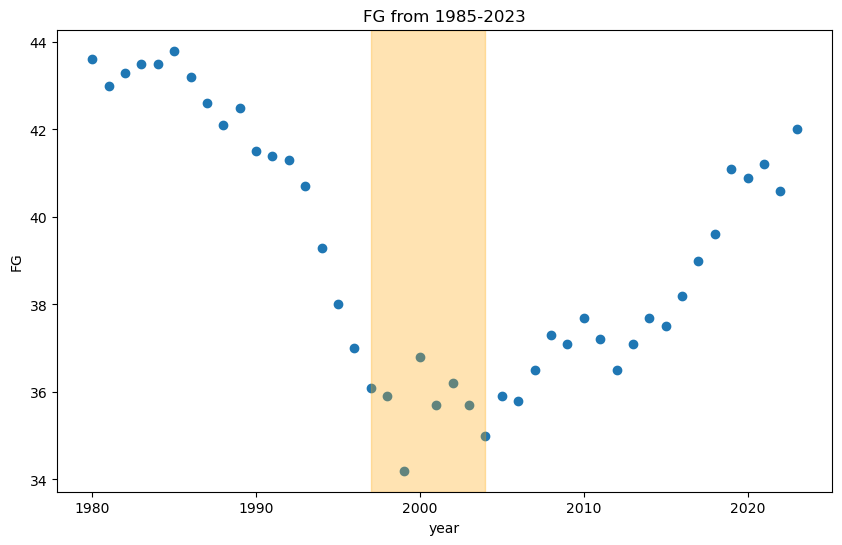

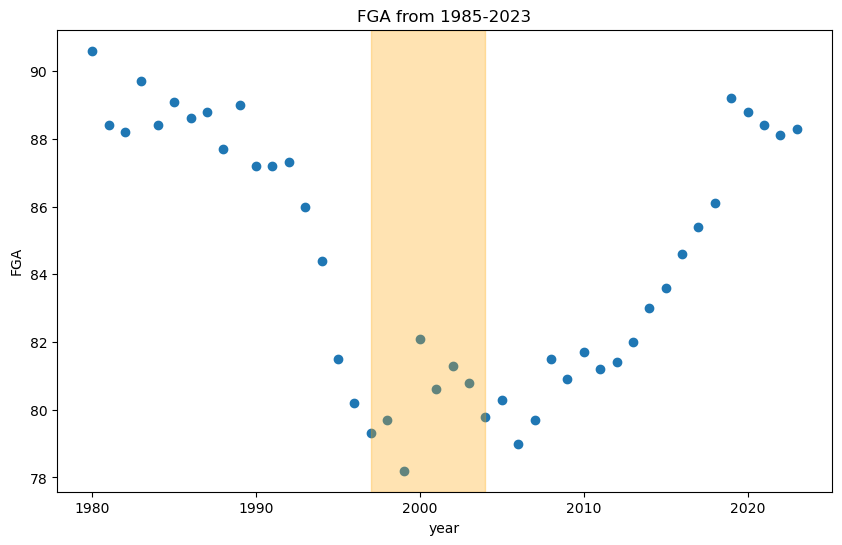

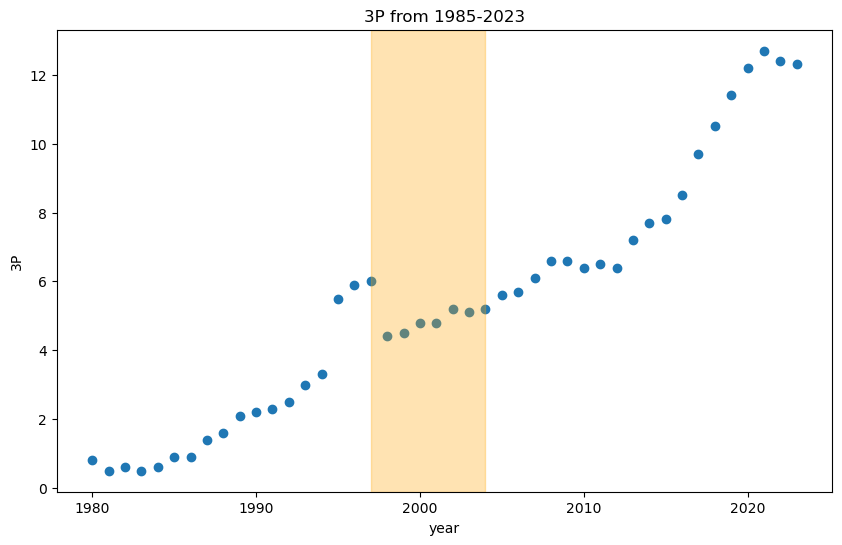

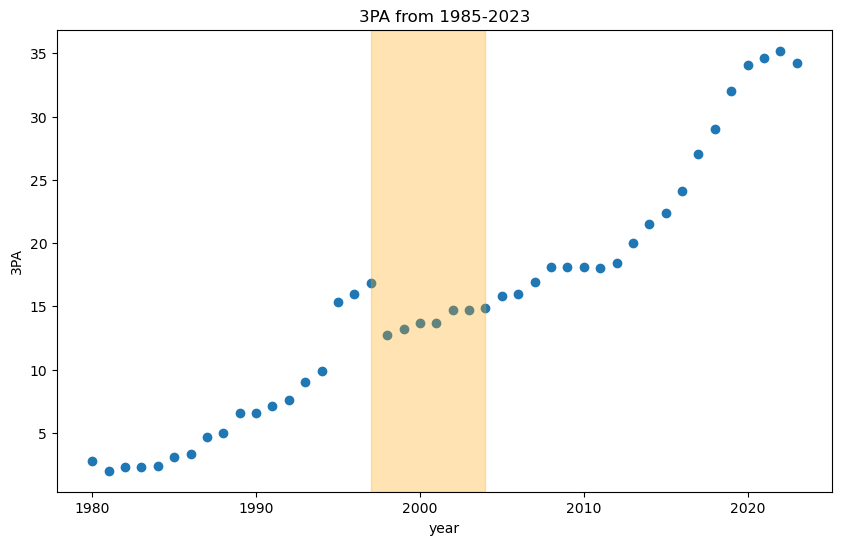

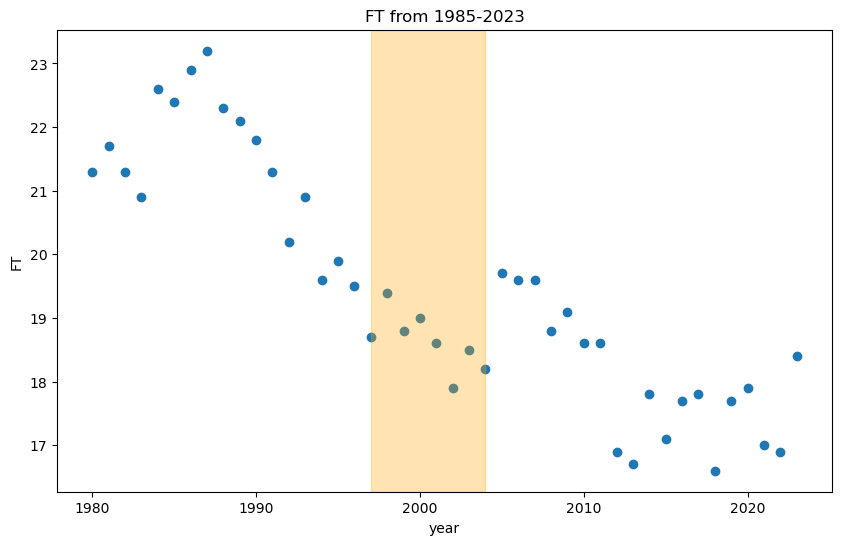

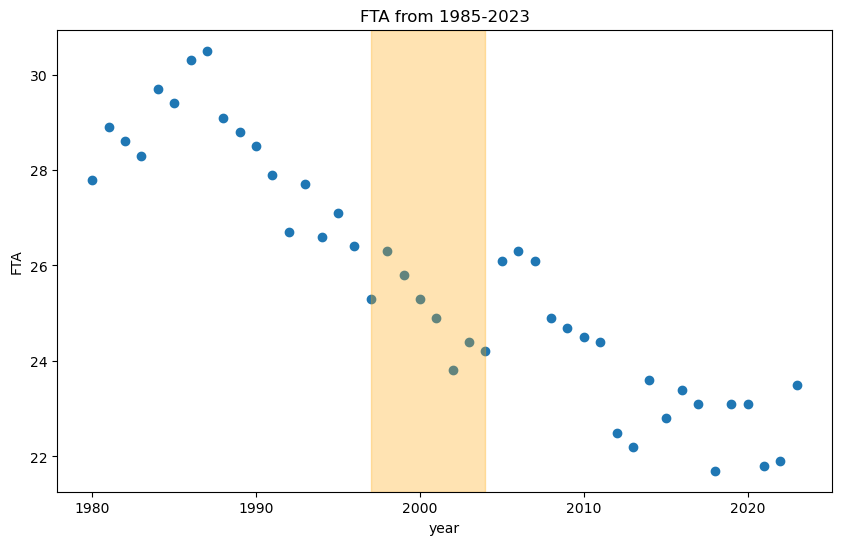

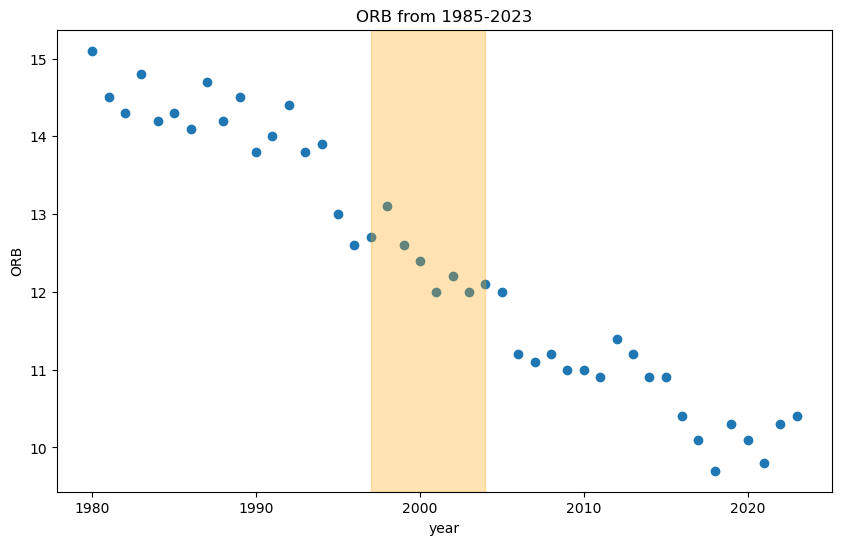

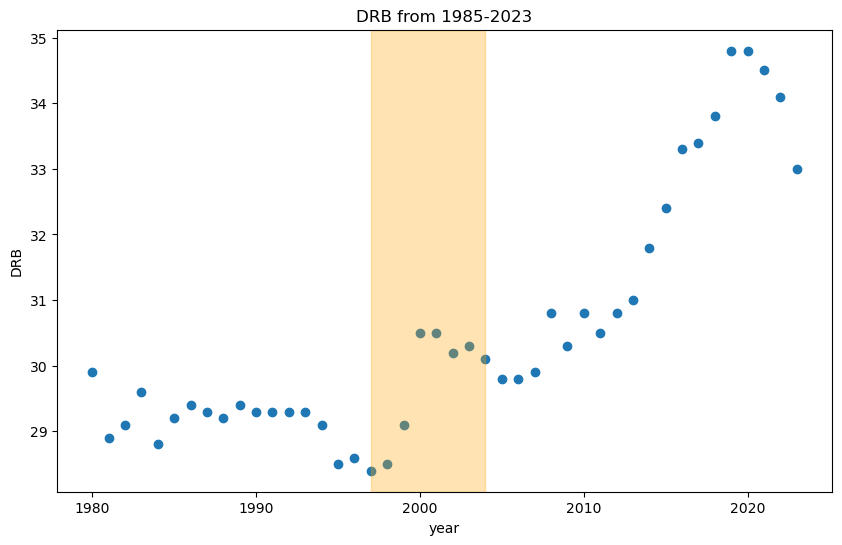

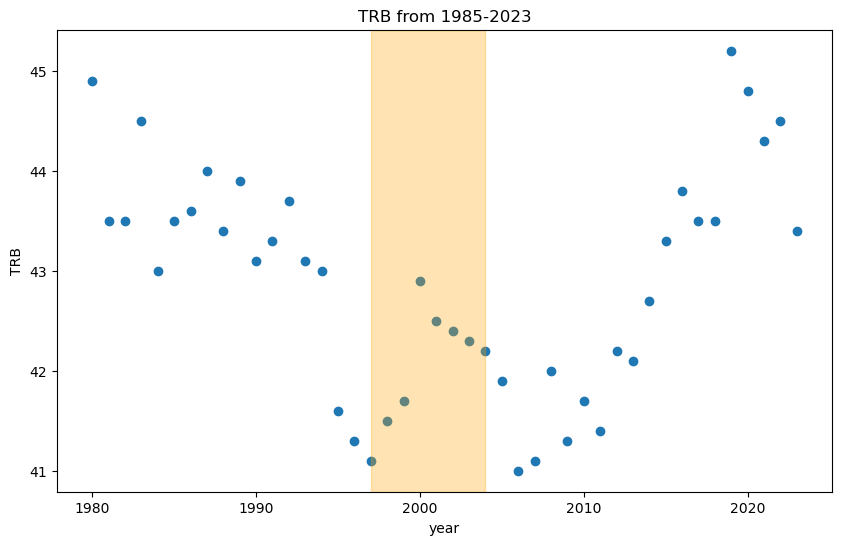

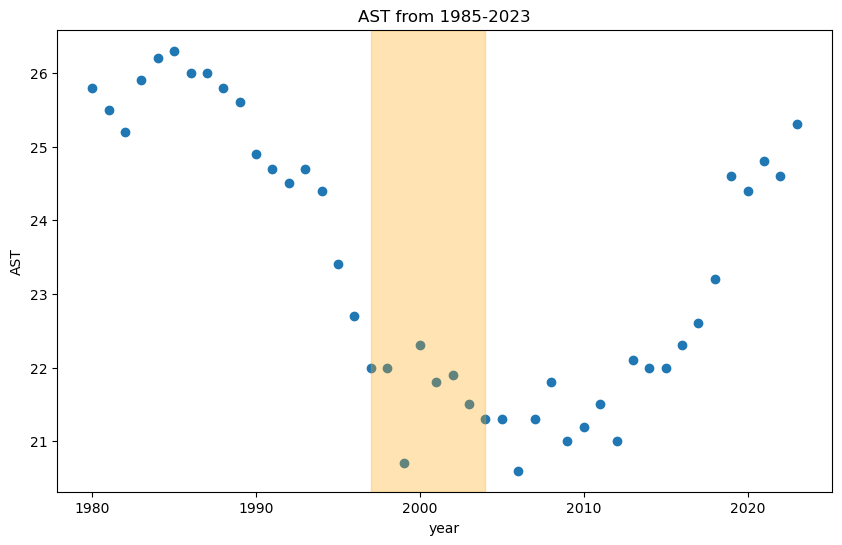

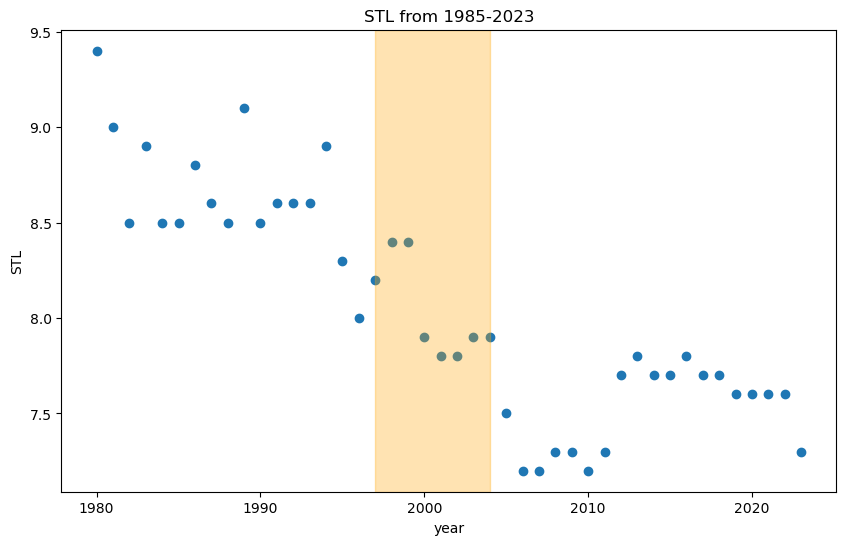

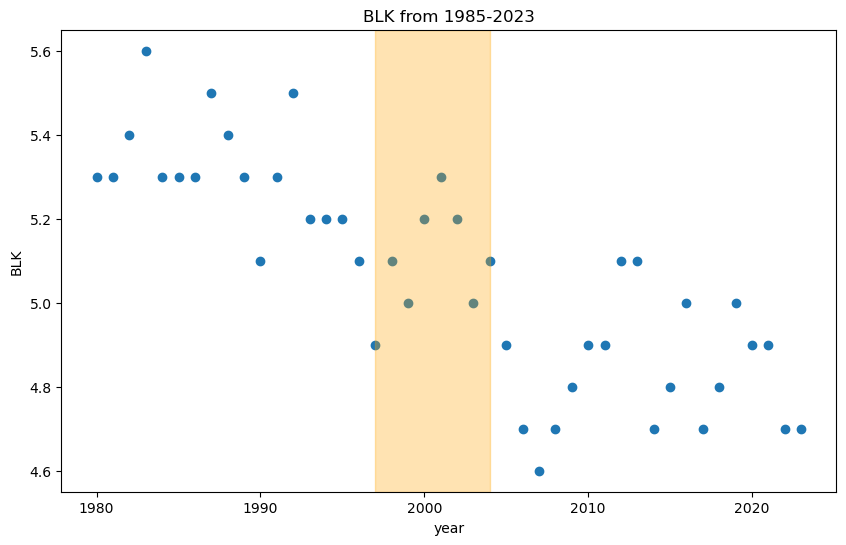

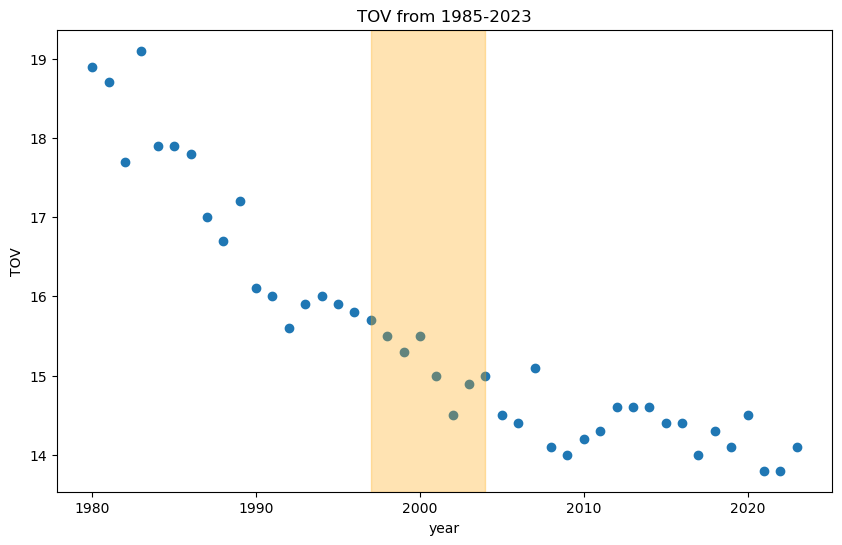

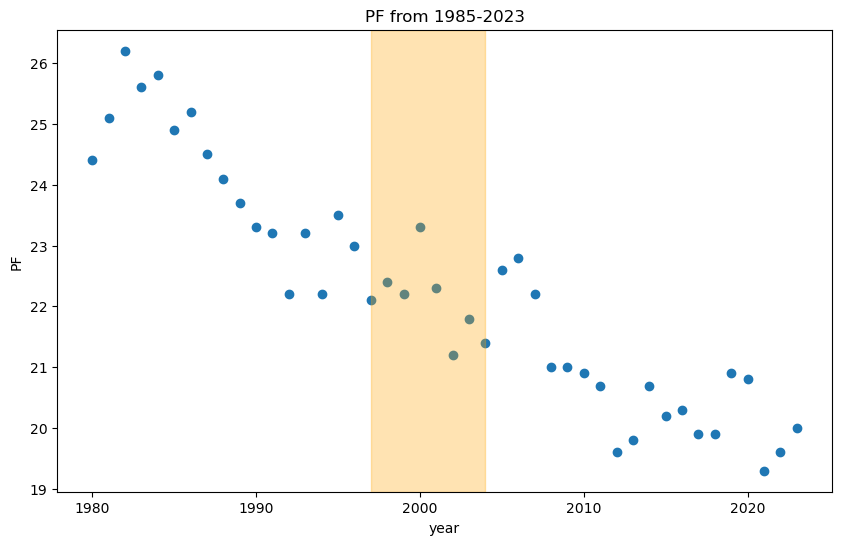

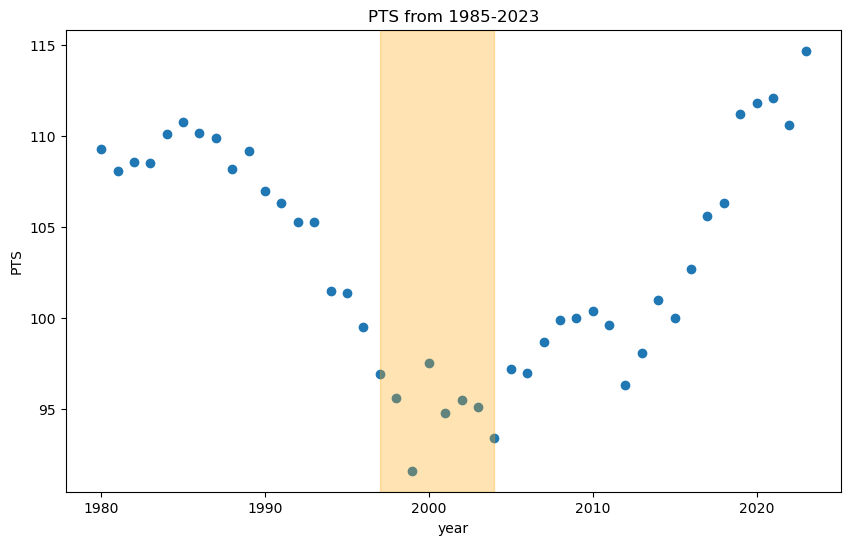

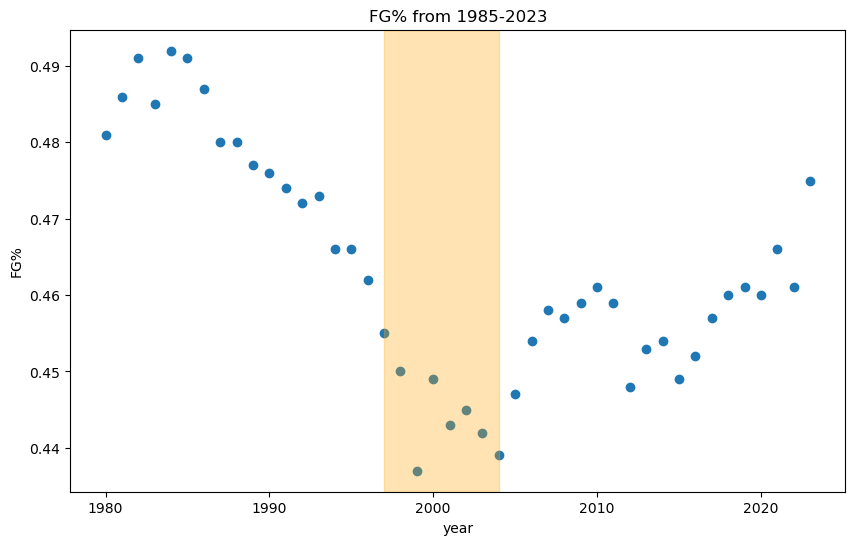

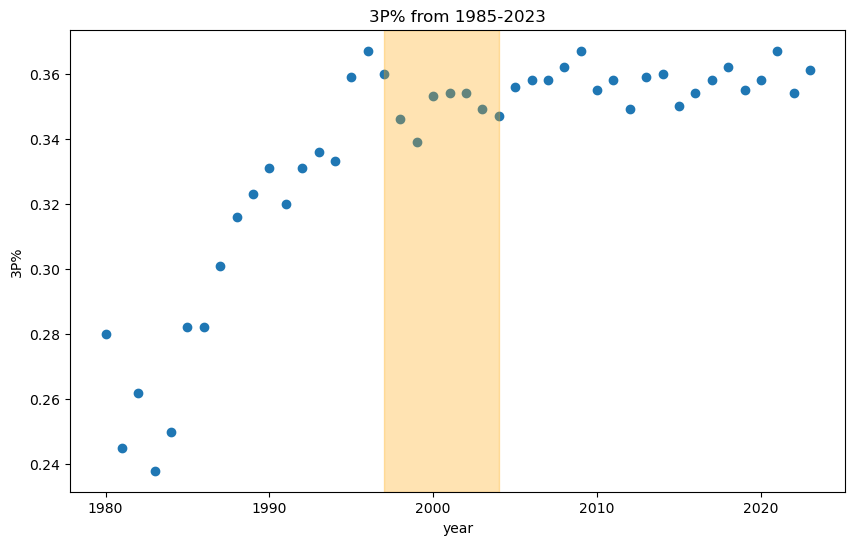

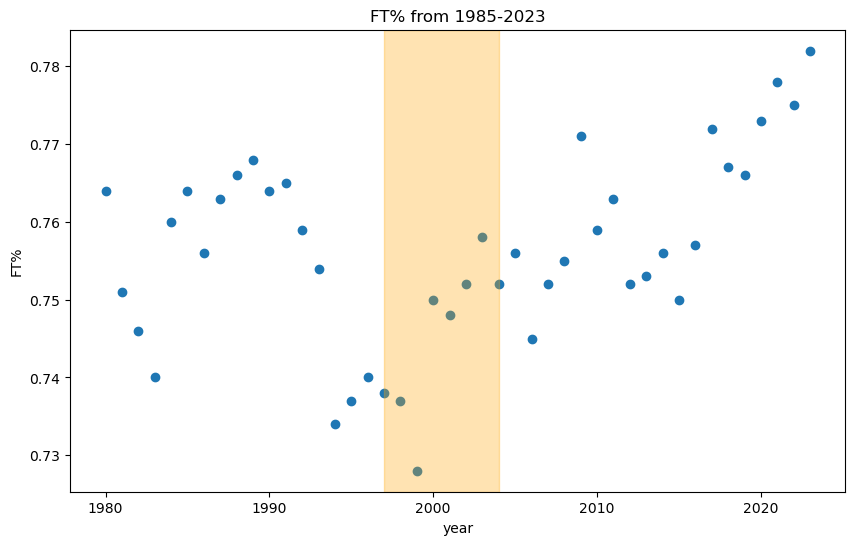

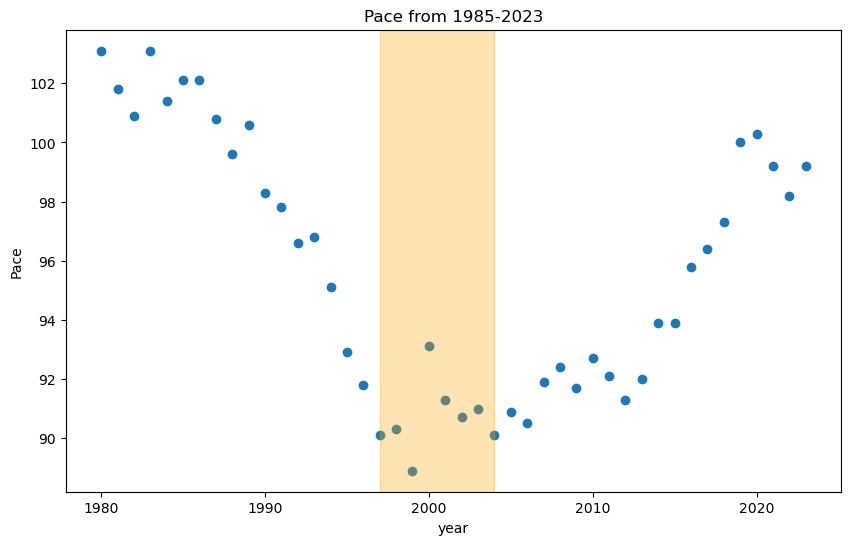

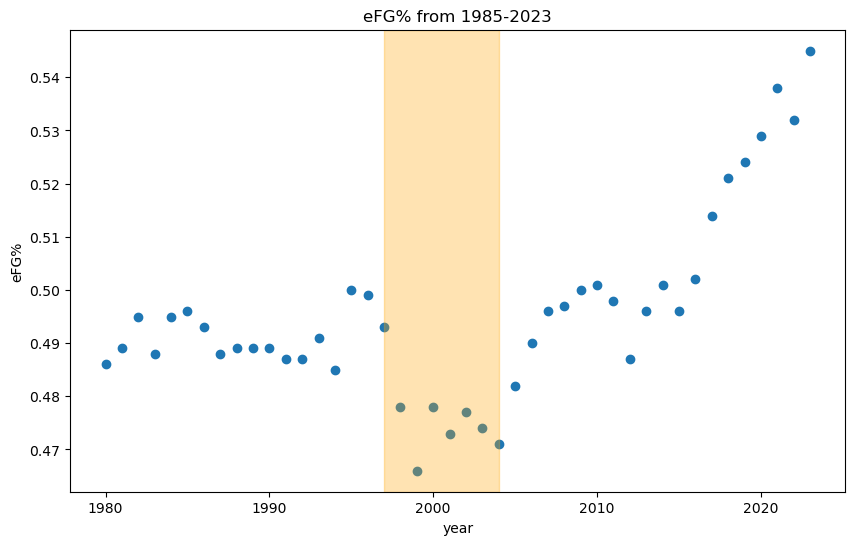

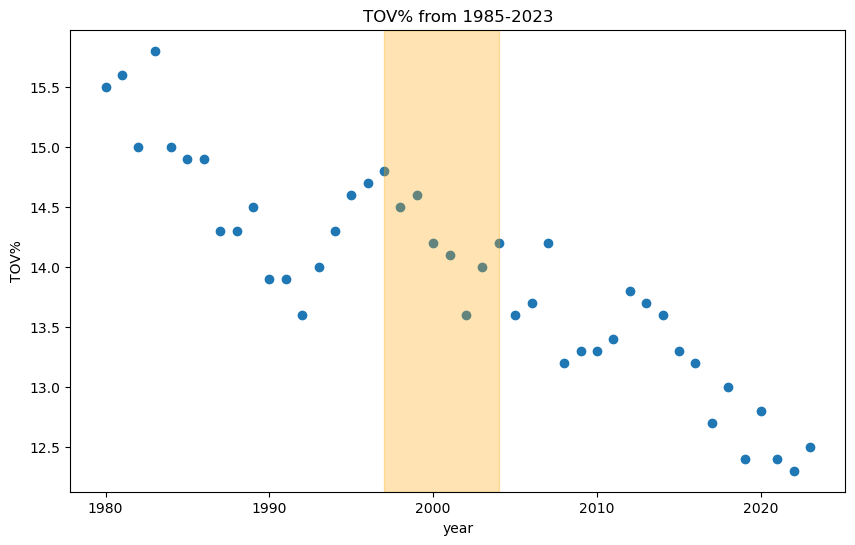

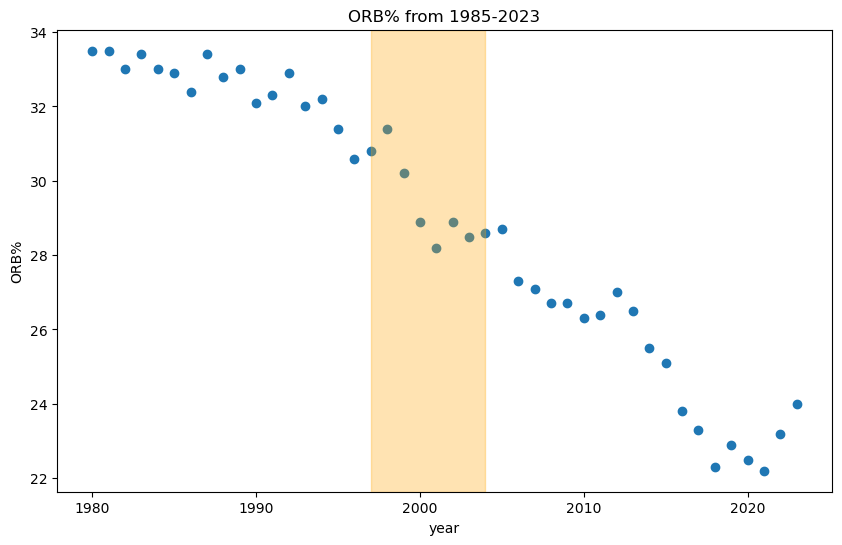

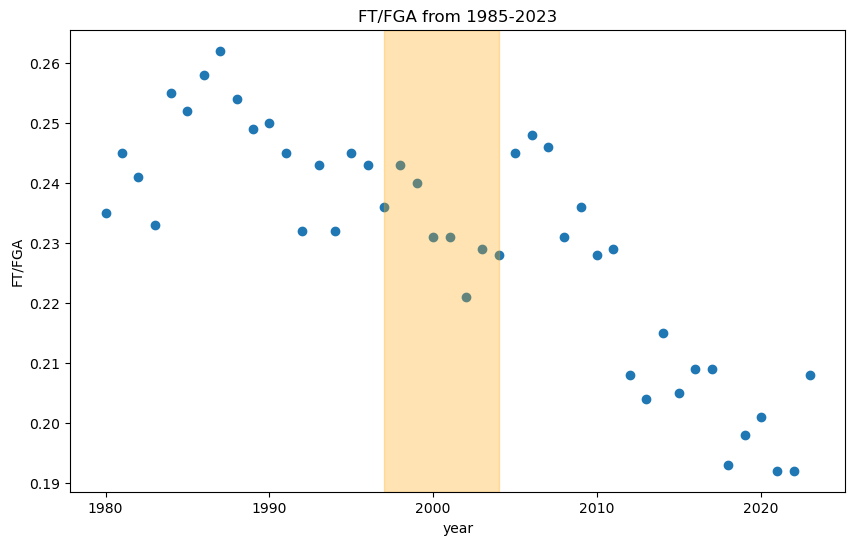

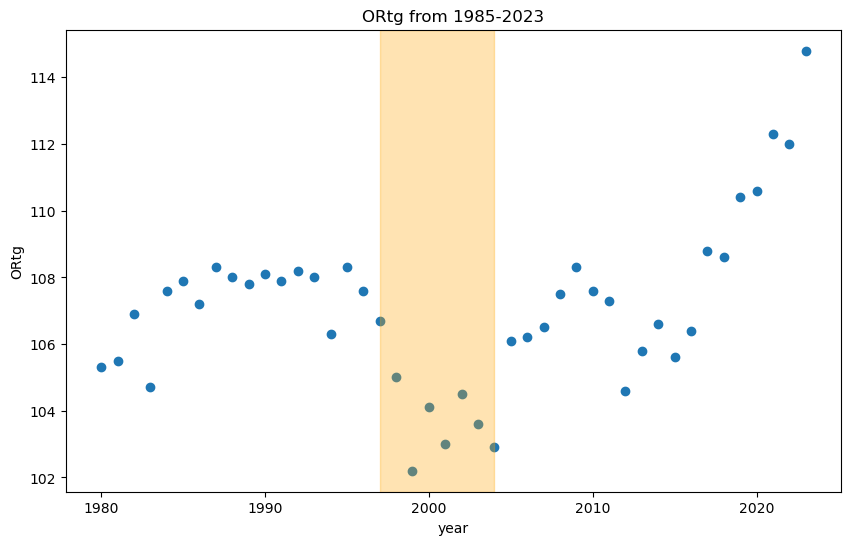

,Season,FG,FGA,3P,3PA,FT,FTA,ORB,DRB,TRB,...,PTS,FG%,3P%,FT%,Pace,eFG%,TOV%,ORB%,FT/FGA,ORtg
0,2023,42.0,88.3,12.3,34.2,18.4,23.5,10.4,33.0,43.4,...,114.7,0.475,0.361,0.782,99.2,0.545,12.5,24.0,0.208,114.8
1,2022,40.6,88.1,12.4,35.2,16.9,21.9,10.3,34.1,44.5,...,110.6,0.461,0.354,0.775,98.2,0.532,12.3,23.2,0.192,112.0
2,2021,41.2,88.4,12.7,34.6,17.0,21.8,9.8,34.5,44.3,...,112.1,0.466,0.367,0.778,99.2,0.538,12.4,22.2,0.192,112.3
3,2020,40.9,88.8,12.2,34.1,17.9,23.1,10.1,34.8,44.8,...,111.8,0.460,0.358,0.773,100.3,0.529,12.8,22.5,0.201,110.6
4,2019,41.1,89.2,11.4,32.0,17.7,23.1,10.3,34.8,45.2,...,111.2,0.461,0.355,0.766,100.0,0.524,12.4,22.9,0.198,110.4
5,2018,39.6,86.1,10.5,29.0,16.6,21.7,9.7,33.8,43.5,...,106.3,0.460,0.362,0.767,97.3,0.521,13.0,22.3,0.193,108.6
6,2017,39.0,85.4,9.7,27.0,17.8,23.1,10.1,33.4,43.5,...,105.6,0.457,0.358,0.772,96.4,0.514,12.7,23.3,0.209,108.8
7,2016,38.2,84.6,8.5,24.1,17.7,23.4,10.4,33.3,43.8,...,102.7,0.452,0.354,0.757,95.8,0.502,13.2,23.8,0.209,106.4
8,2015,37.5,83.6,7.8,22.4,17.1,22.8,10.9,32.4,43.3,...,100.0,0.449,0.350,0.750,93.9,0.496,13.3,25.1,0.205,105.6
9,2014,37.7,83.0,7.7,21.5,17.8,23.6,10.9,31.8,42.7,...,101.0,0.454,0.360,0.756,93.9,0.501,13.6,25.5,0.215,106.6


In [5]:
#Retrieve league-wide NBA data from Basketball-Reference
r3 = requests.get("https://www.basketball-reference.com/leagues/NBA_stats_per_game.html")
print(r3.status_code)
league_soup = bs(r3.content)
league_table = league_soup.find("table")
league_df = pd.read_html(str(league_table))[0]
league_df = league_df[(league_df['Per Game', 'MP'] != 'Per Game') | (league_df['Per Game','MP'] != 'MP')]
league_df = league_df.drop(index=[20, 21, 42, 43])
league_df = league_df.iloc[1:45]
cpy = league_df.copy()
cpy.columns = ['_'.join(col).strip() for col in league_df.columns.values]
df_flat = cpy.reset_index()

for cols in df_flat.columns:
    try:
        df_flat[cols] = pd.to_numeric(df_flat[cols])
    except:
        continue

league_df = df_flat
league_df.drop(columns='index')
league_df.columns = [label.split('_')[-1] for label in league_df.columns.values]
league_df = league_df.drop(columns=['index', 'Rk', 'Lg', 'Age', 'Ht', 'Wt', 'G', 'MP'])
league_df['Season'] = [int(years.split('-')[0]) + 1 for years in league_df['Season'].values]

#Plot league-wide statistics
x = league_df['Season'] 
data = league_df.drop(columns=['Season'])
for stat in data.columns.values:
    fig, ax = plt.subplots(figsize = (10, 6))
    ax.scatter(x, data[stat])
    plt.title(stat + " from 1985-2023")
    plt.xlabel("year")
    plt.ylabel(stat)
    plt.axvspan(1997, 2004, color='orange', alpha=0.3)
    plt.show()

league_df

There was an interesting trend that emerged for a few statistics. For FG, FGA, PTS, and Pace there is a clear nonlinear pattern in the data. Specifically, the graphs for these metrics have a parabolic shape, decreasing as time progresses starting in 1980, bottoming out somewhere in 1997-2004, and increasing from there. Interestingly, 3 significant rule changes in this period may have affected scoring during this time. The first one was in 1997 when the restricted area, an area within the paint where you can't draw charges, was instituted. This made defense more difficult and would lead to more offense in theory. In 2001, the NBA eliminated the illegal defense rule where defenders could not be more than an arm's length away from an offensive player for more than three seconds and instituted another, the defensive three seconds, which mandates a defender must not remain in the paint for more than 3 seconds. This rule change essentially legalized zone defense, making it easier for defenders to guard isolation-heavy players who, before the rule change, would essentially be given an entire half of the court to operate 1-on-1 with a defender. This may have had an unintentional consequence of increasing pace by hampering isolation players and encouraging more ball movement which tends to be quicker offense. Increasing pace, measured in team possessions per 48 minutes, would lead to more FGA which leads to more FG and more PTS. Lastly, in 2004 the NBA started enforcing handchecking where defenders were able to keep their hands on offensive players and impeded their movement. This rule change would have benefited the offensive side of the ball and made for more scoring. eFG% and ORtg show a similar trend, but there is not much of a decrease before these rule changes, there is more of a constant trend, then there is a dip during the rule change period of 1997-2004 and an increase not too long after that. These statistical trends could also be a result of broader NBA trends like the more three-point shooting, the success of Mike D'Antoni's 7-seconds-or-less offense and the teams that have tried to mimic it since, the growth of positionless basketball, some combination of everything I've mentioned, or none of them entirely. Whatever the cause may be, it's clear to see that the NBA underwent seismic changes during this time making comparisons across eras difficult, even within the same position.

In [6]:
#change datatypes of df
df['Age'] = df['Age'].astype(int)
for cols in df.columns:
    try:
        df[cols] = pd.to_numeric(df[cols])
    except:
        continue
#Seperating the data for starters
#Starter - a player who starts more games than they come off the bench in the games that they play
starters = df[(df["G"] - (df["GS"]) <= df["GS"])& (df["GS"] >= 20)]
pts = []
temp = []
for year in starters['Year'].unique():
    temp = starters[starters['Year'] == year]['PTS'].tolist()
    pts.append(temp)
    
max_len = max(len(row) for row in pts)
d = [row + [None] * (max_len - len(row)) for row in pts]

#Retrieve play-by-play data from Basketball-Reference. Will be used to resolve player positions to the single position they play the most
year = 1997
req = requests.get(f"https://www.basketball-reference.com/leagues/NBA_{year}_play-by-play.html")

pbp_soup = bs(req.content)
pbp_table = pbp_soup.find("table")
pbp = pd.read_html(str(pbp_table))[0]
pbp["Year"] = year

for year in range(1998, 2024):
    req = requests.get(f"https://www.basketball-reference.com/leagues/NBA_{year}_play-by-play.html")
    pbp_soup = bs(req.content)
    pbp_table = pbp_soup.find("table")
    temp = pd.read_html(str(pbp_table))[0]
    temp["Year"] = year
    pbp = pd.concat([pbp, temp], ignore_index=True)
    time.sleep(4)

#Fix pbp columns
cpy = pbp.copy()
cpy.columns = ['_'.join(col).strip() for col in pbp.columns.values]
df_flat = cpy.reset_index()
df_flat = df_flat.drop(columns="index")
pbp.columns = [label.split('_')[-1] for label in df_flat.columns.values]

pbp = pbp.rename(columns={'': "Year"})
pbp = pbp[pbp["C%"] != "C%"]
#pbp = pbp.drop(columns=["Rk", "Age", "G", "MP", "OnCourt", "On-Off", "BadPass", "LostBall", "Shoot", "Off.", "Shoot", "Off.", "PGA", "And1", "Blkd"])
for cols in pbp.columns:
    try:
        pbp[cols] = pd.to_numeric(pbp[cols].str.rstrip('%'))
    except:
        continue

cols = pbp.columns.tolist()
cols = cols[-2:] + cols[:-2]
pbp = pbp[cols]
pbp = pbp.loc[:, "Year":"C%"]
pbp = pbp.drop(columns=["Rk", "MP"])

starters = starters.reset_index().drop(columns="index")
pbp = pbp.reset_index().drop(columns="index")

In [7]:
final = starters.merge(pbp, "left")
#Retrieve per-possesssion statistics from Basketball-Reference for Defensive Ratings
poss = getTables(np.arange(1980, 2024), "https://www.basketball-reference.com/leagues/NBA_", "_per_poss.html", pd.DataFrame())
poss["Player"] = poss["Player"].str.replace('*', '')
poss = poss.drop(columns=poss.loc[:, "MP":"ORtg"])
poss = poss.drop(columns="Rk")
poss = poss[poss["Player"] != "Player"]
for cols in poss.columns:
    try:
        poss[cols] = pd.to_numeric(poss[cols])
    except:
        continue
final = final.merge(poss, 'left')
#Set each players position to be the single most column they play most according to the play-by-play data, if they do not have play-by-play data
#reset the players position to what it was before
final["Pos"] = final.loc[:, "PG%":"C%"].idxmax(axis="columns")
final["Pos"] = final["Pos"].fillna(starters["Pos"])
final["Pos"] = final["Pos"].str.rstrip("%")
final["Pos"] = [pos.split("-")[0] for pos in final["Pos"].values]
starters = final

Cross-position comparisons are even more difficult. As mentioned above, the NBA has trended towards positionless basketball where the positional responsibilities typically attributed to certain positions are being loosened. Point guards once thought to be past first and focused on assists now are among the most prolific scorers in the league. Centers once were tethered to the low block, responsible for patrolling the paint on defense, and seldomly took any three-point jump shots. In today's NBA, big men who can't shoot the three-pointer are often played off the floor, especially if you can't keep up with perimeter players on defense. This means that the average player at each position looks different during these eras. The box and whisker plots above display these changes.

In order to better compare players across positions and eras, I will normalize the data with respect to the position and year for 8 statistical categories: Points, Assists, Rebounds, Blocks, Steals, Turnovers, True Shooting Percentage, and Defensive Rating. I chose these 8 stats because I thought they were a good mix of stats that would encapsulate a player's performance on both sides of the ball and also take into account efficiency. There is also little overlap with these stats, with the exception of Defensive Rating where Steals and Blocks are used in the calculation. After I selected the stats I'd use in my comparison found the z-score for all 8 of these stats. The Z-score is calculated by subtracting the sample mean from the observed value and dividing by the standard deviation. The resulting value represents how many standard deviations the observed value is away from the mean. This can be interpreted as how far a player is for average for that particular stat. For defensive rating, a low value is better, but when the Z-score would be negative for good defenders. To get around this I negated the z-score so that good defenders get positive z-scores and bad defenders get negative z-scores like all the other stats. The same holds true for turnovers. After calculating the z-score for all 8 stats, I took the mean to get the average z-score. This is the metric I will use for player comparison.

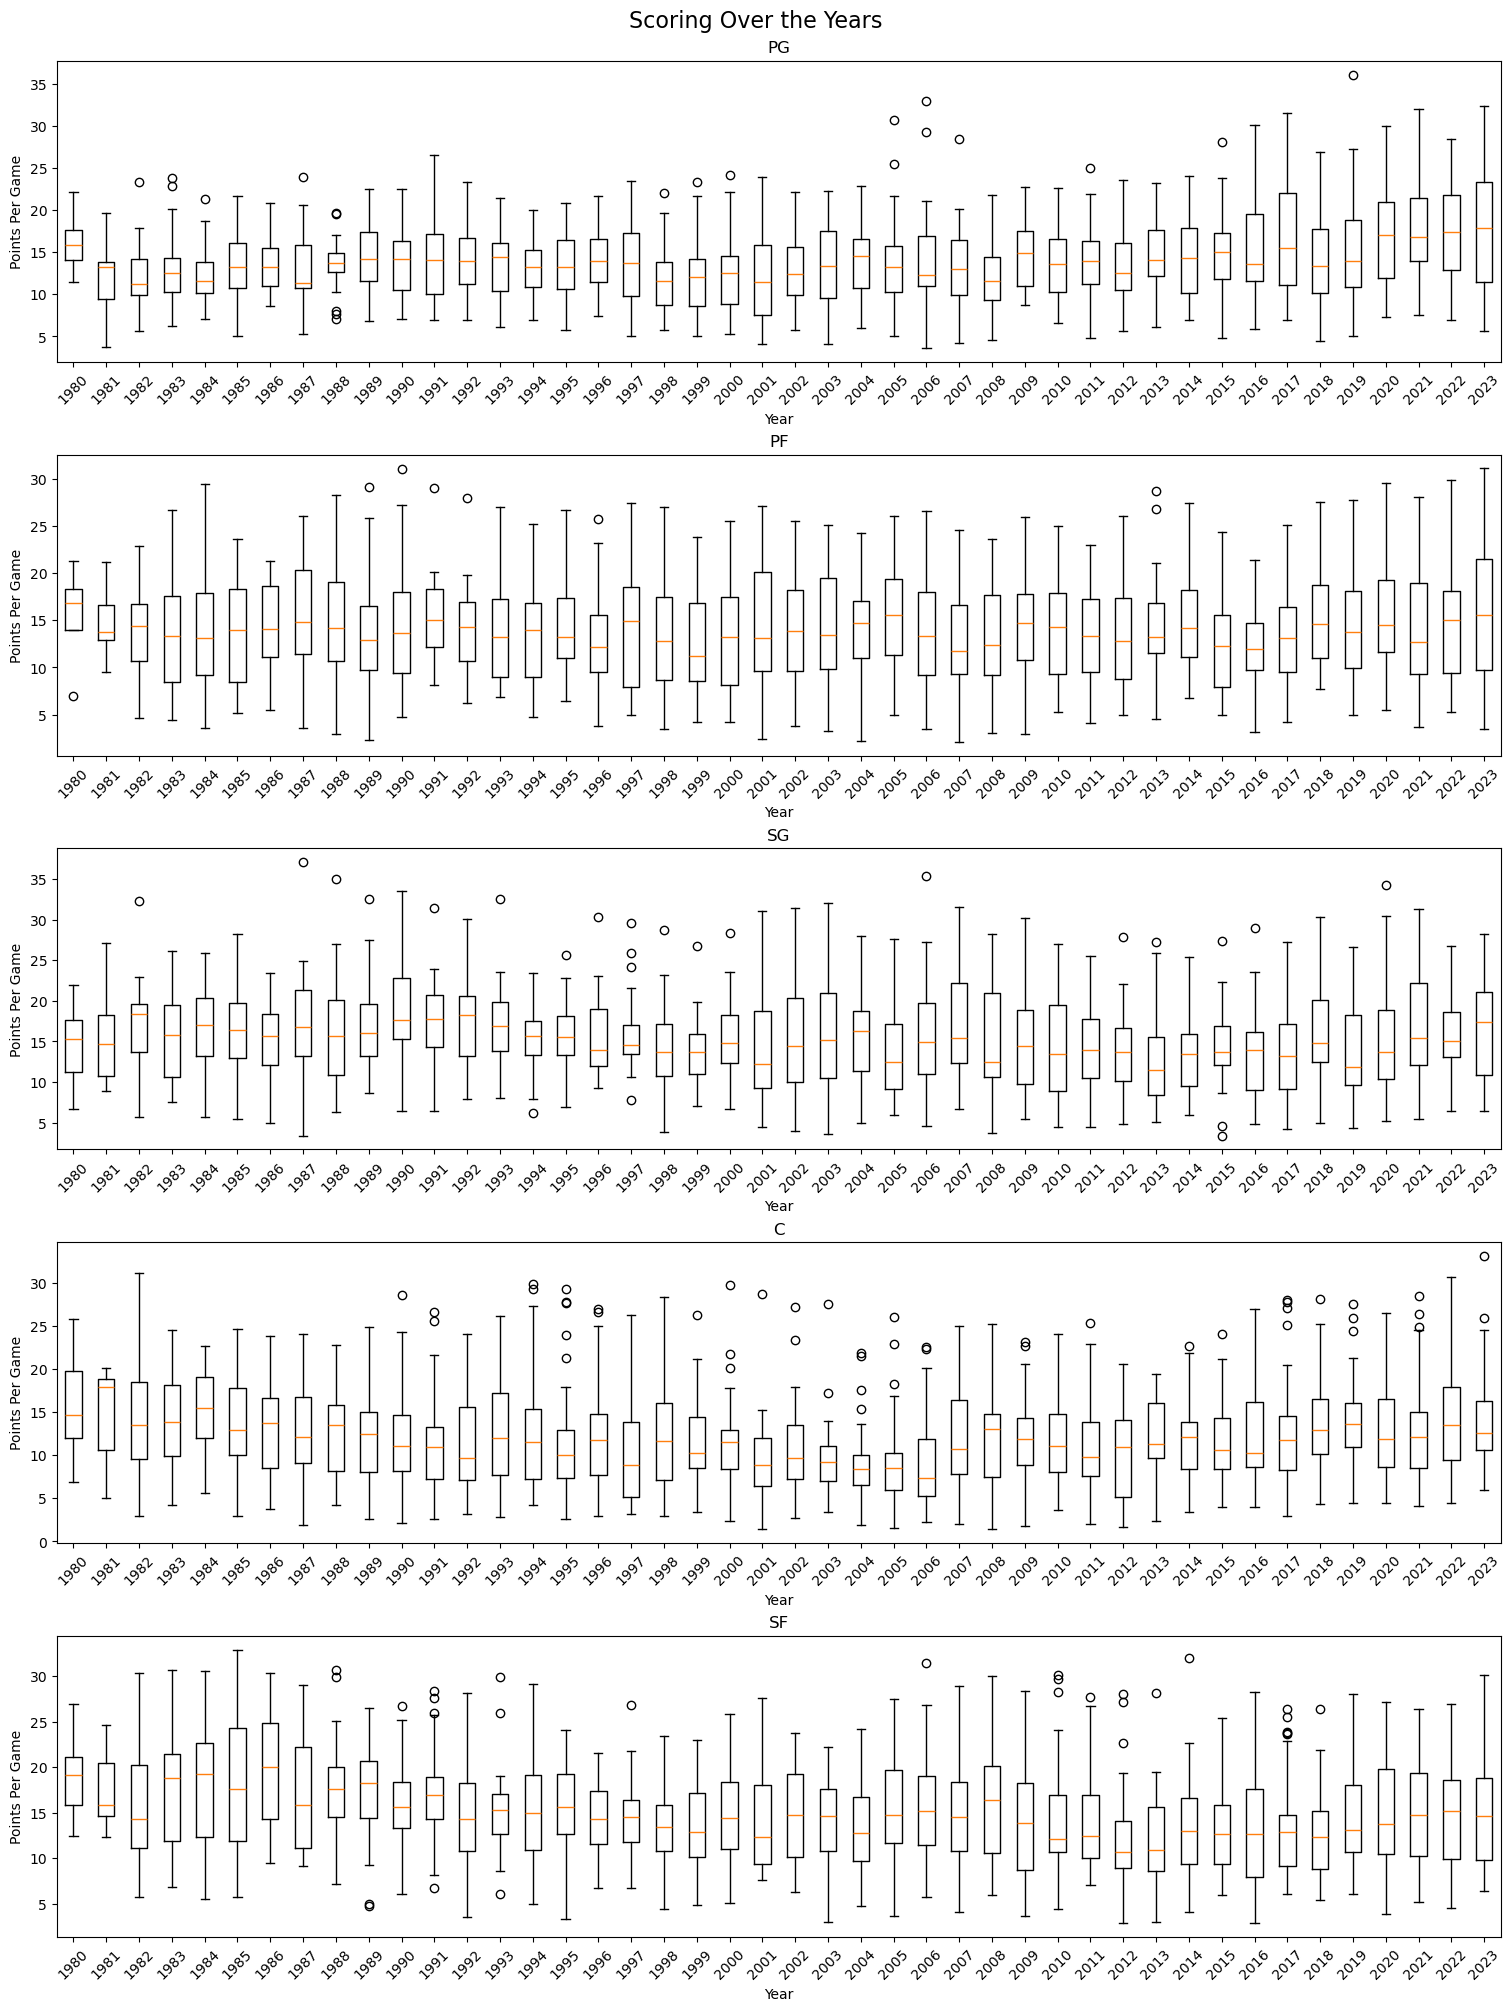

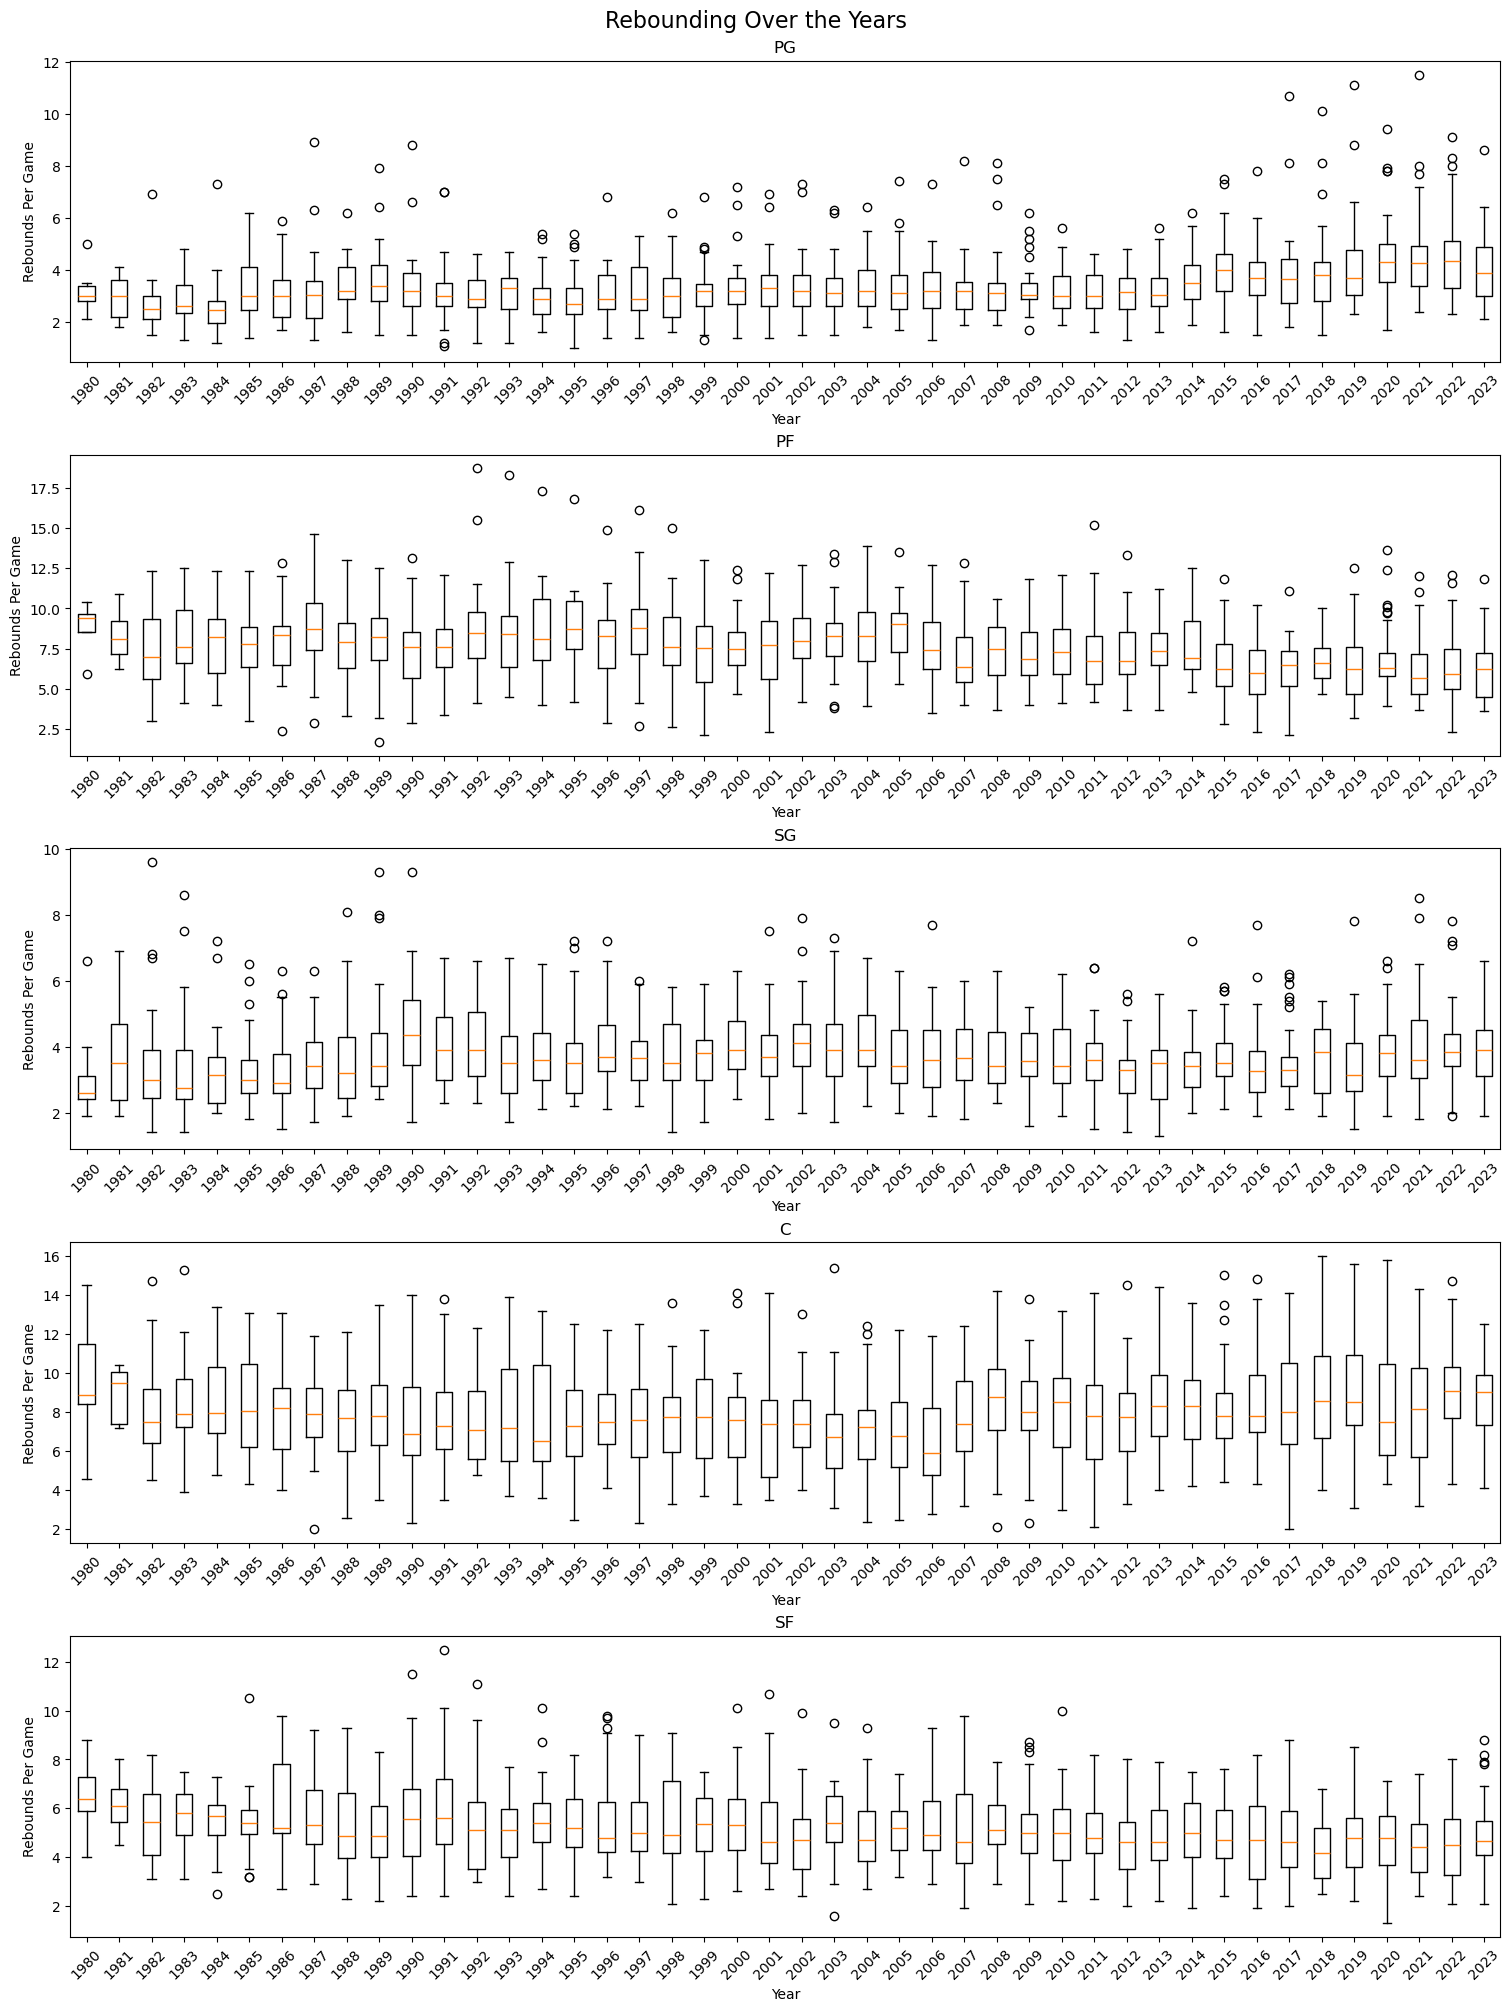

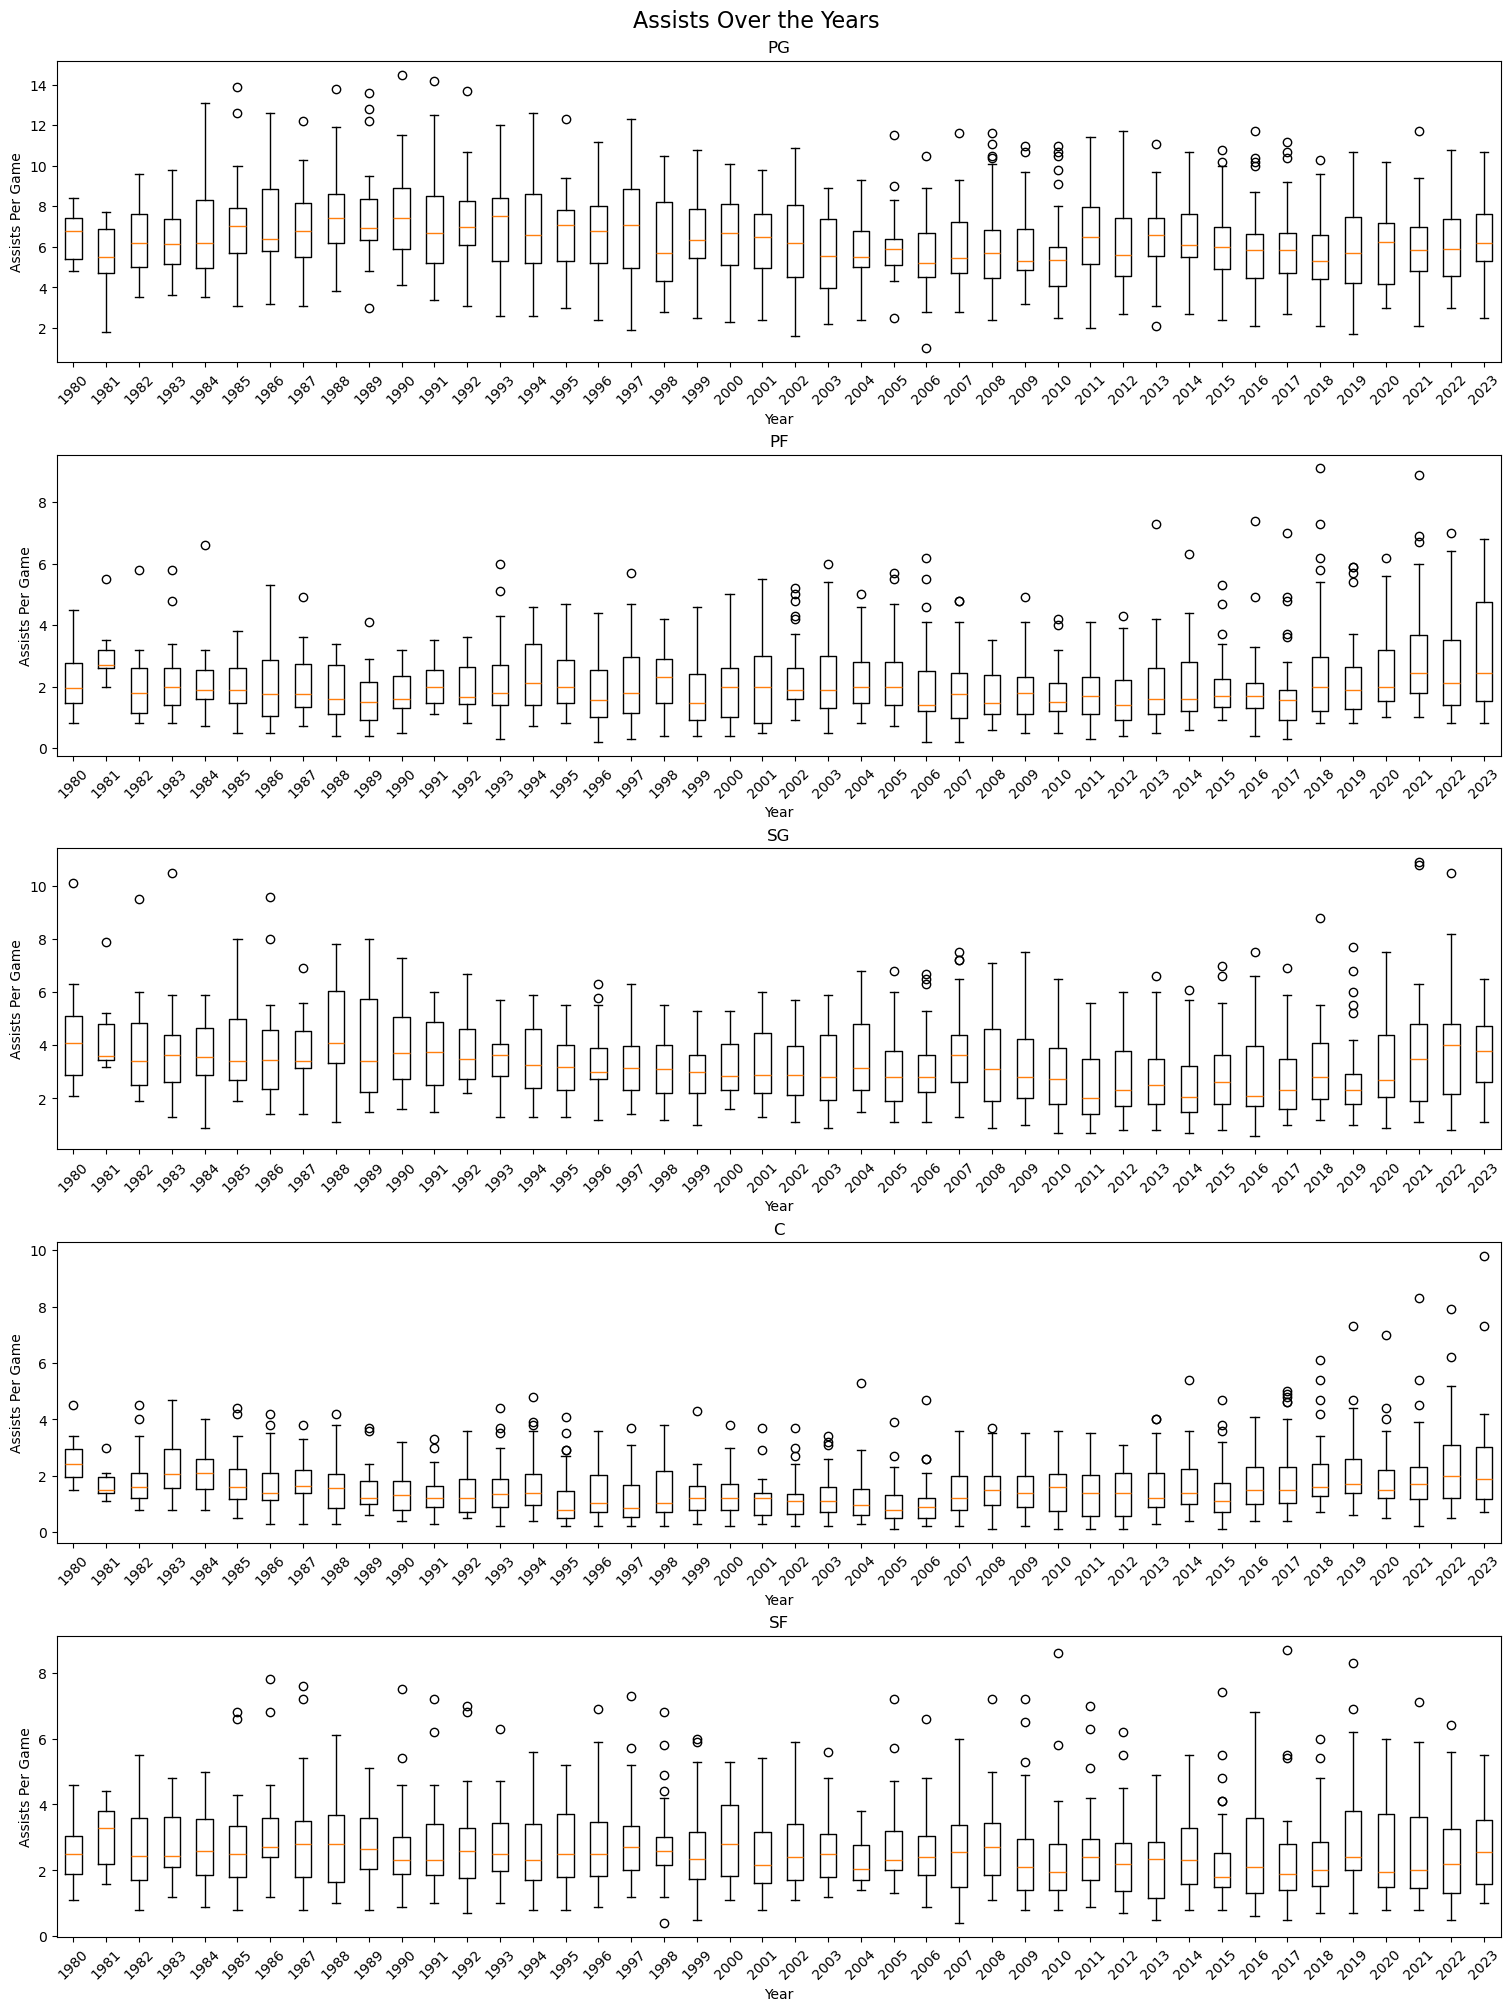

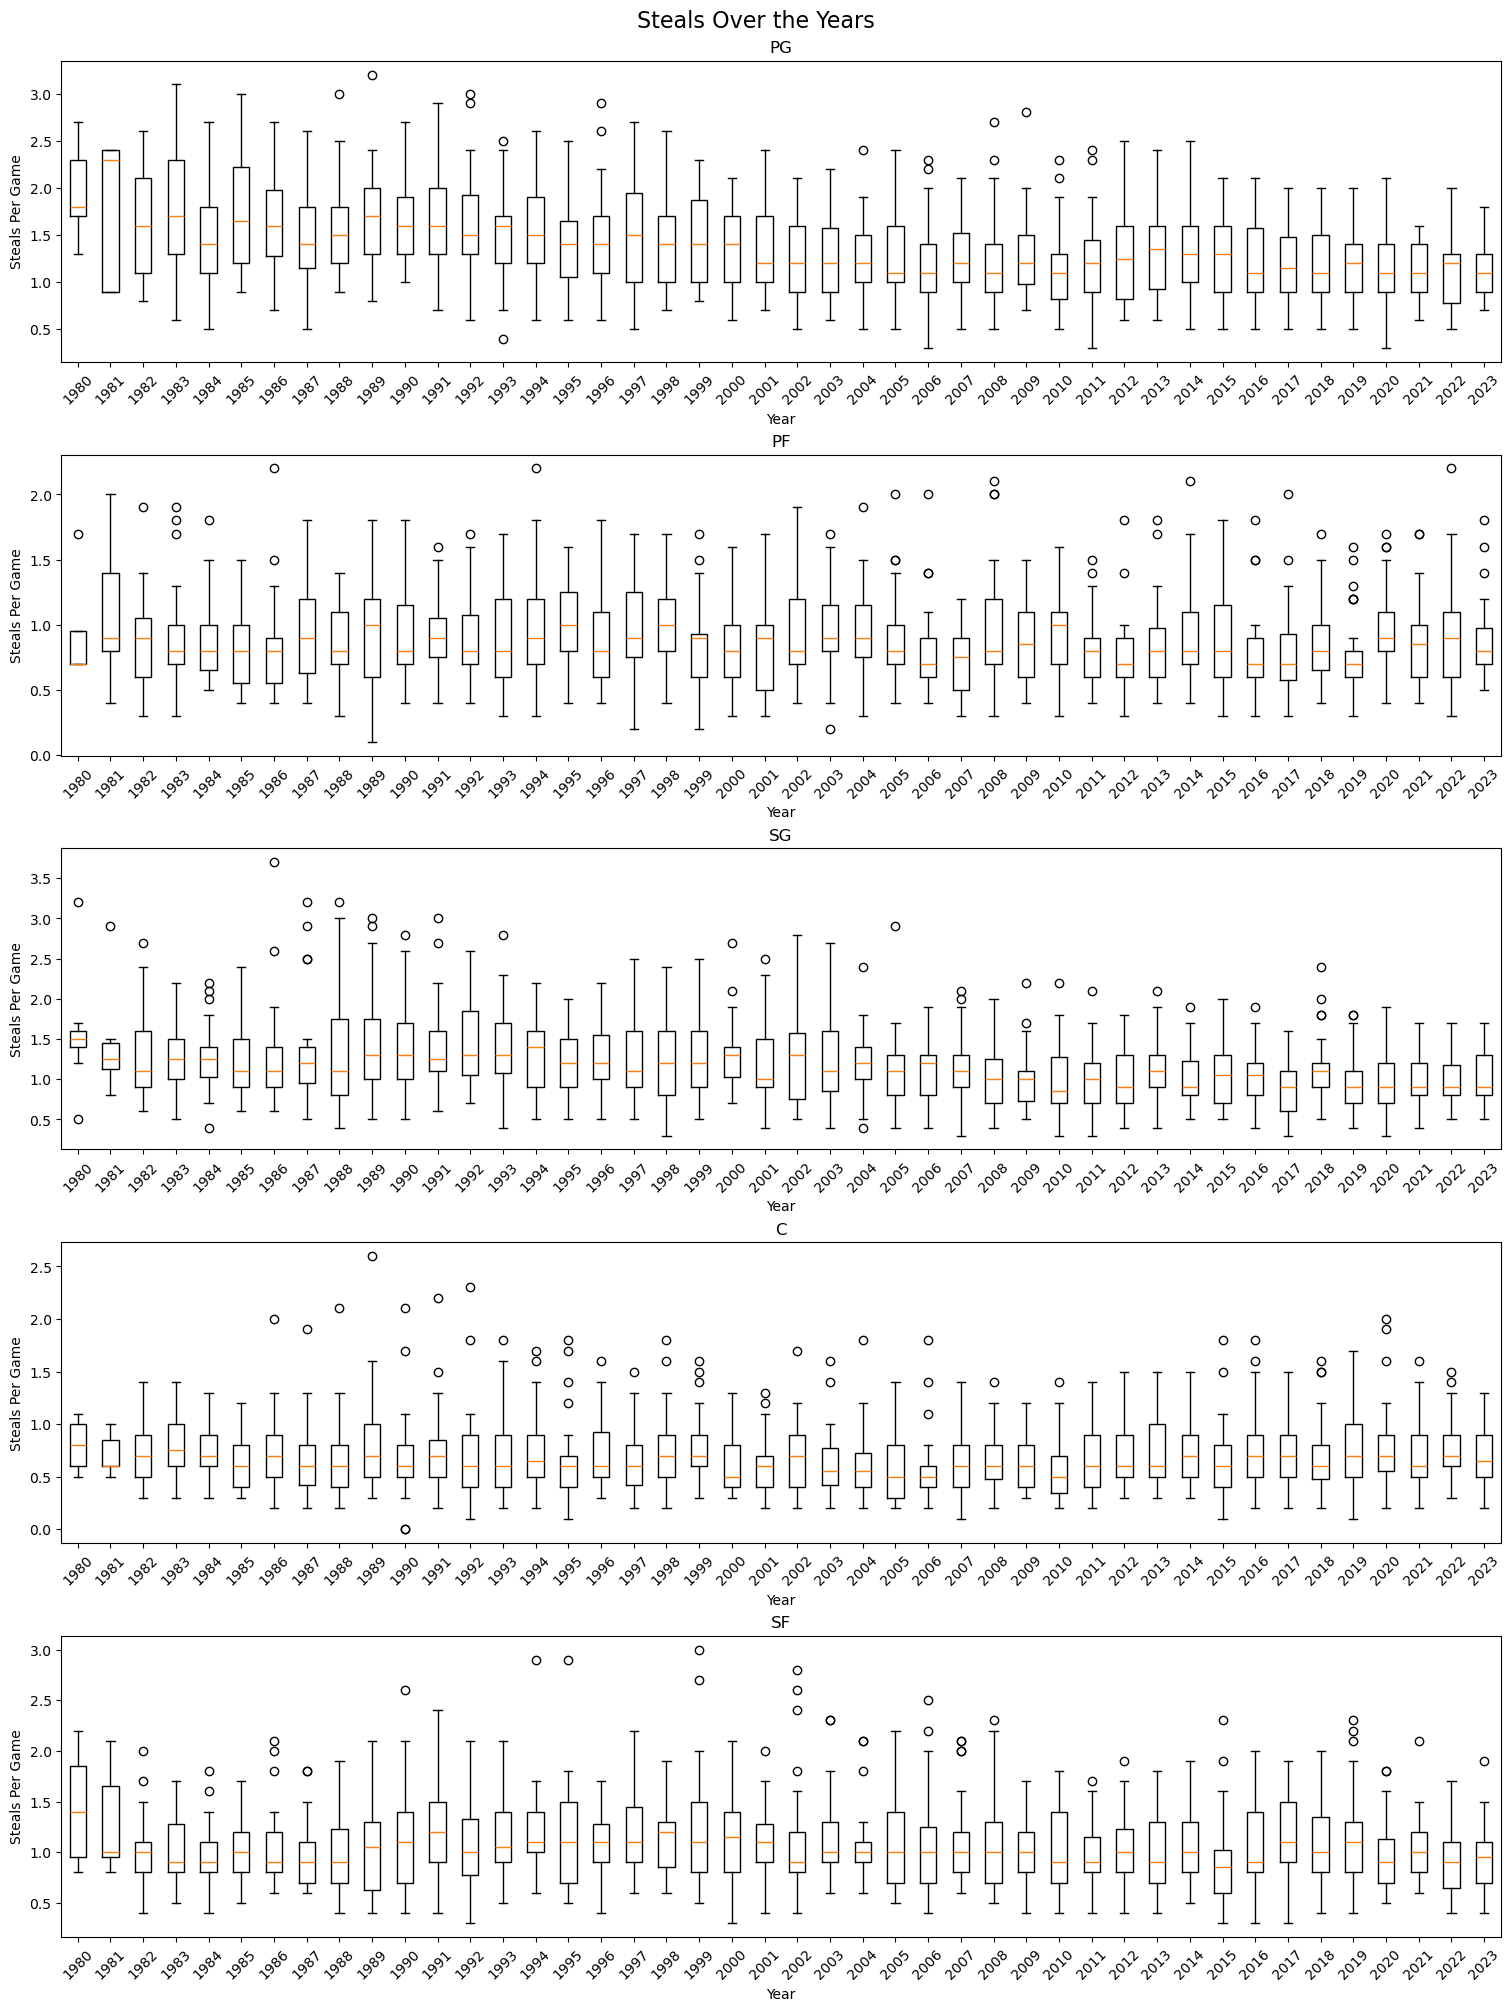

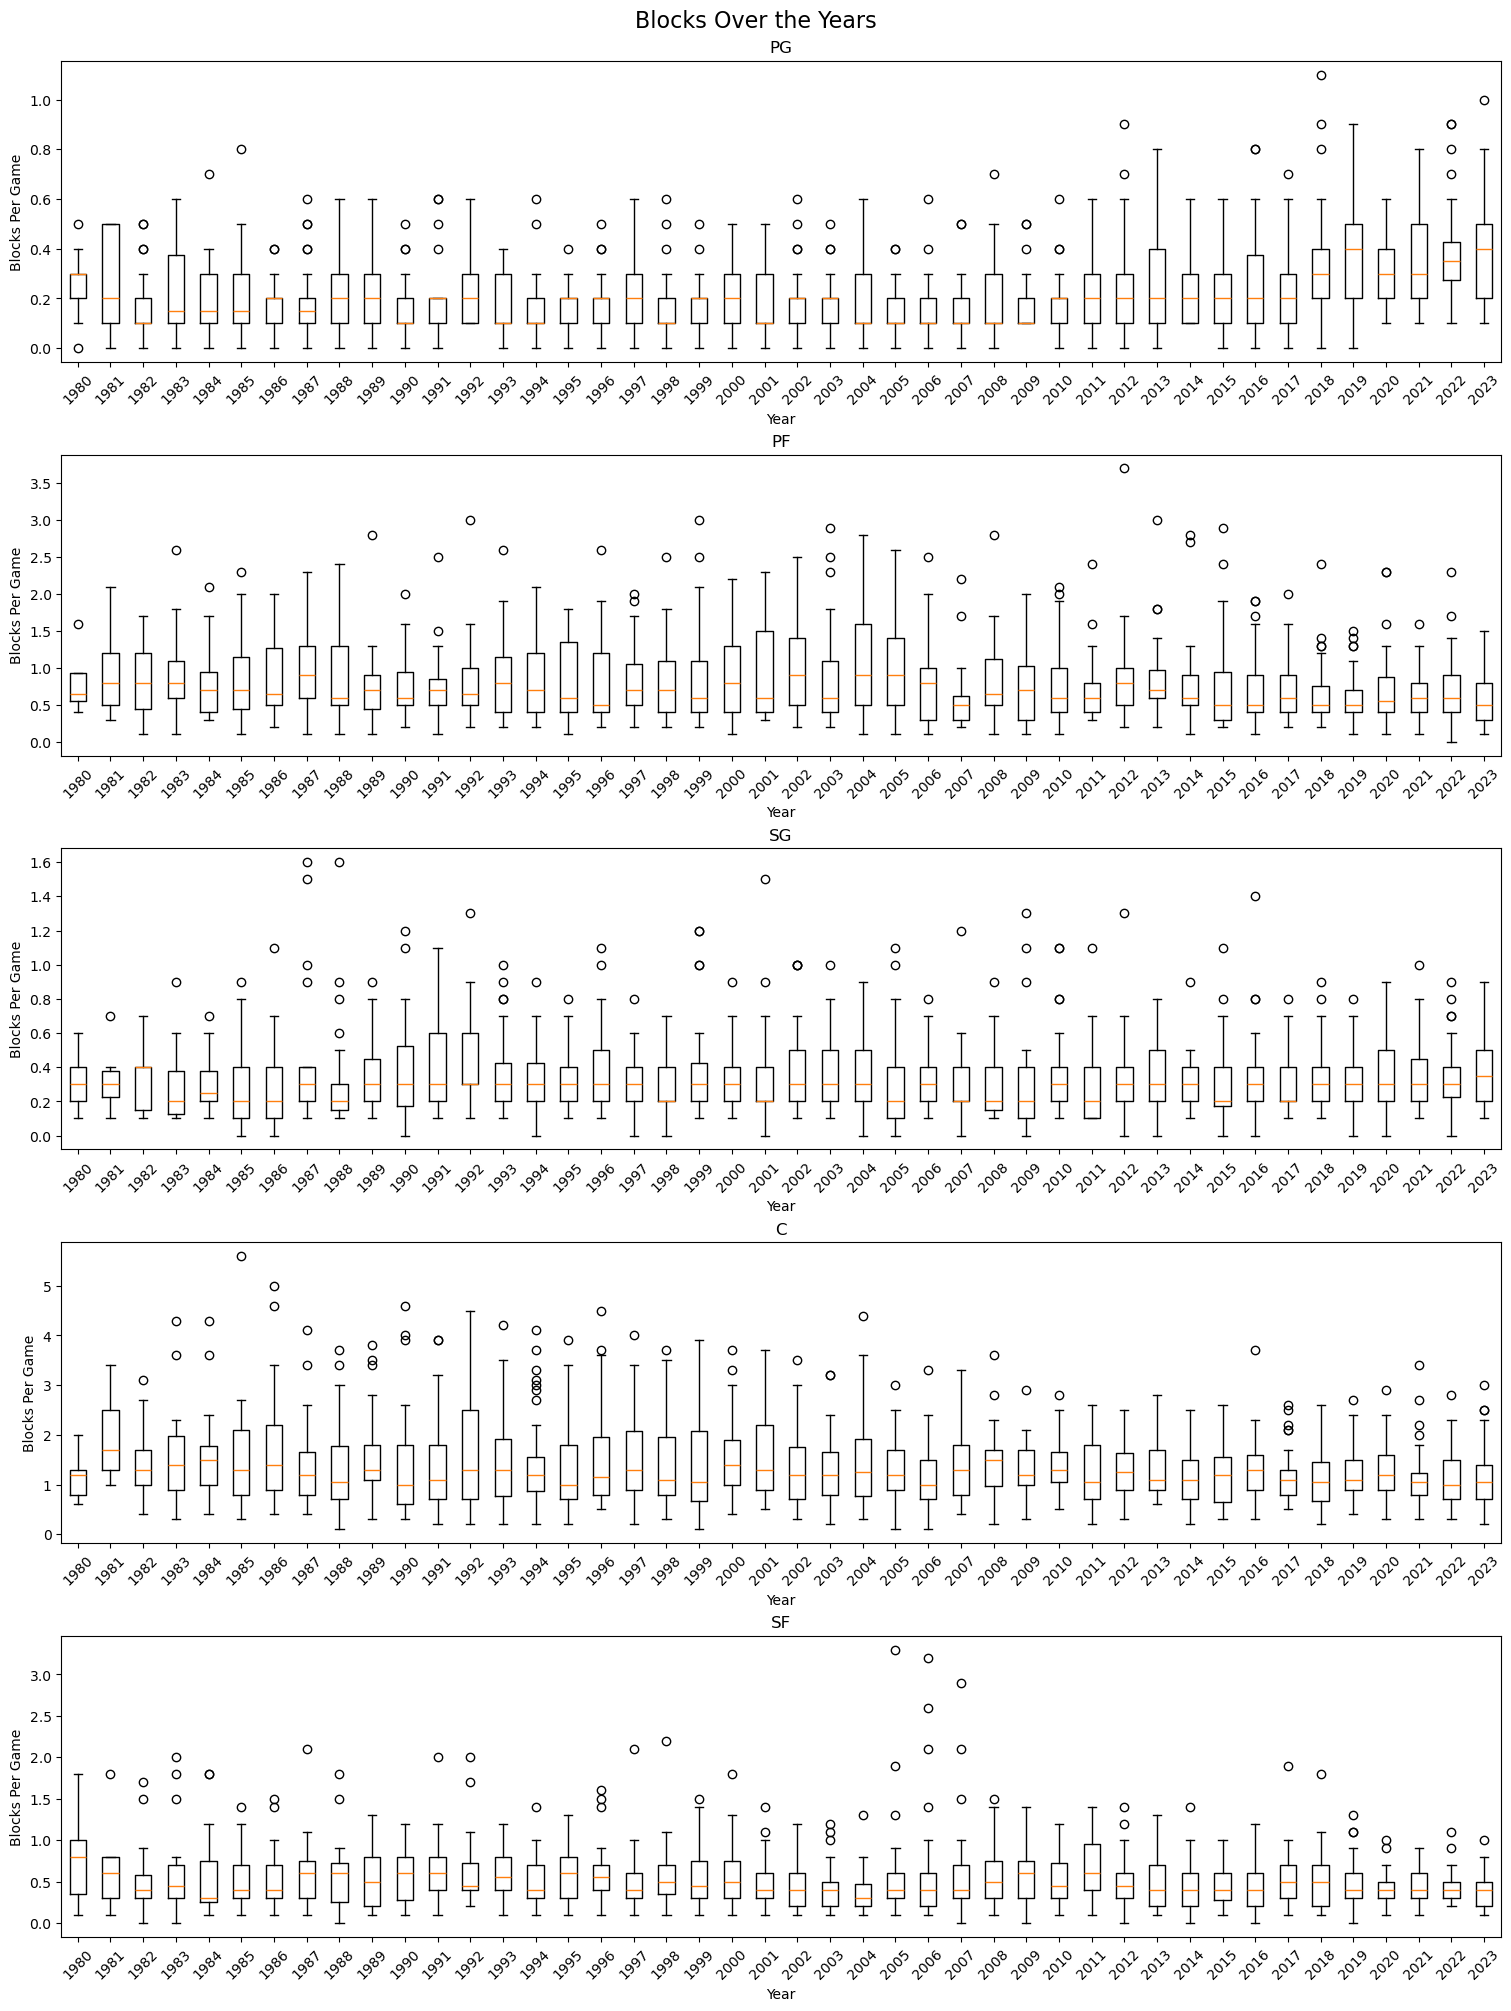

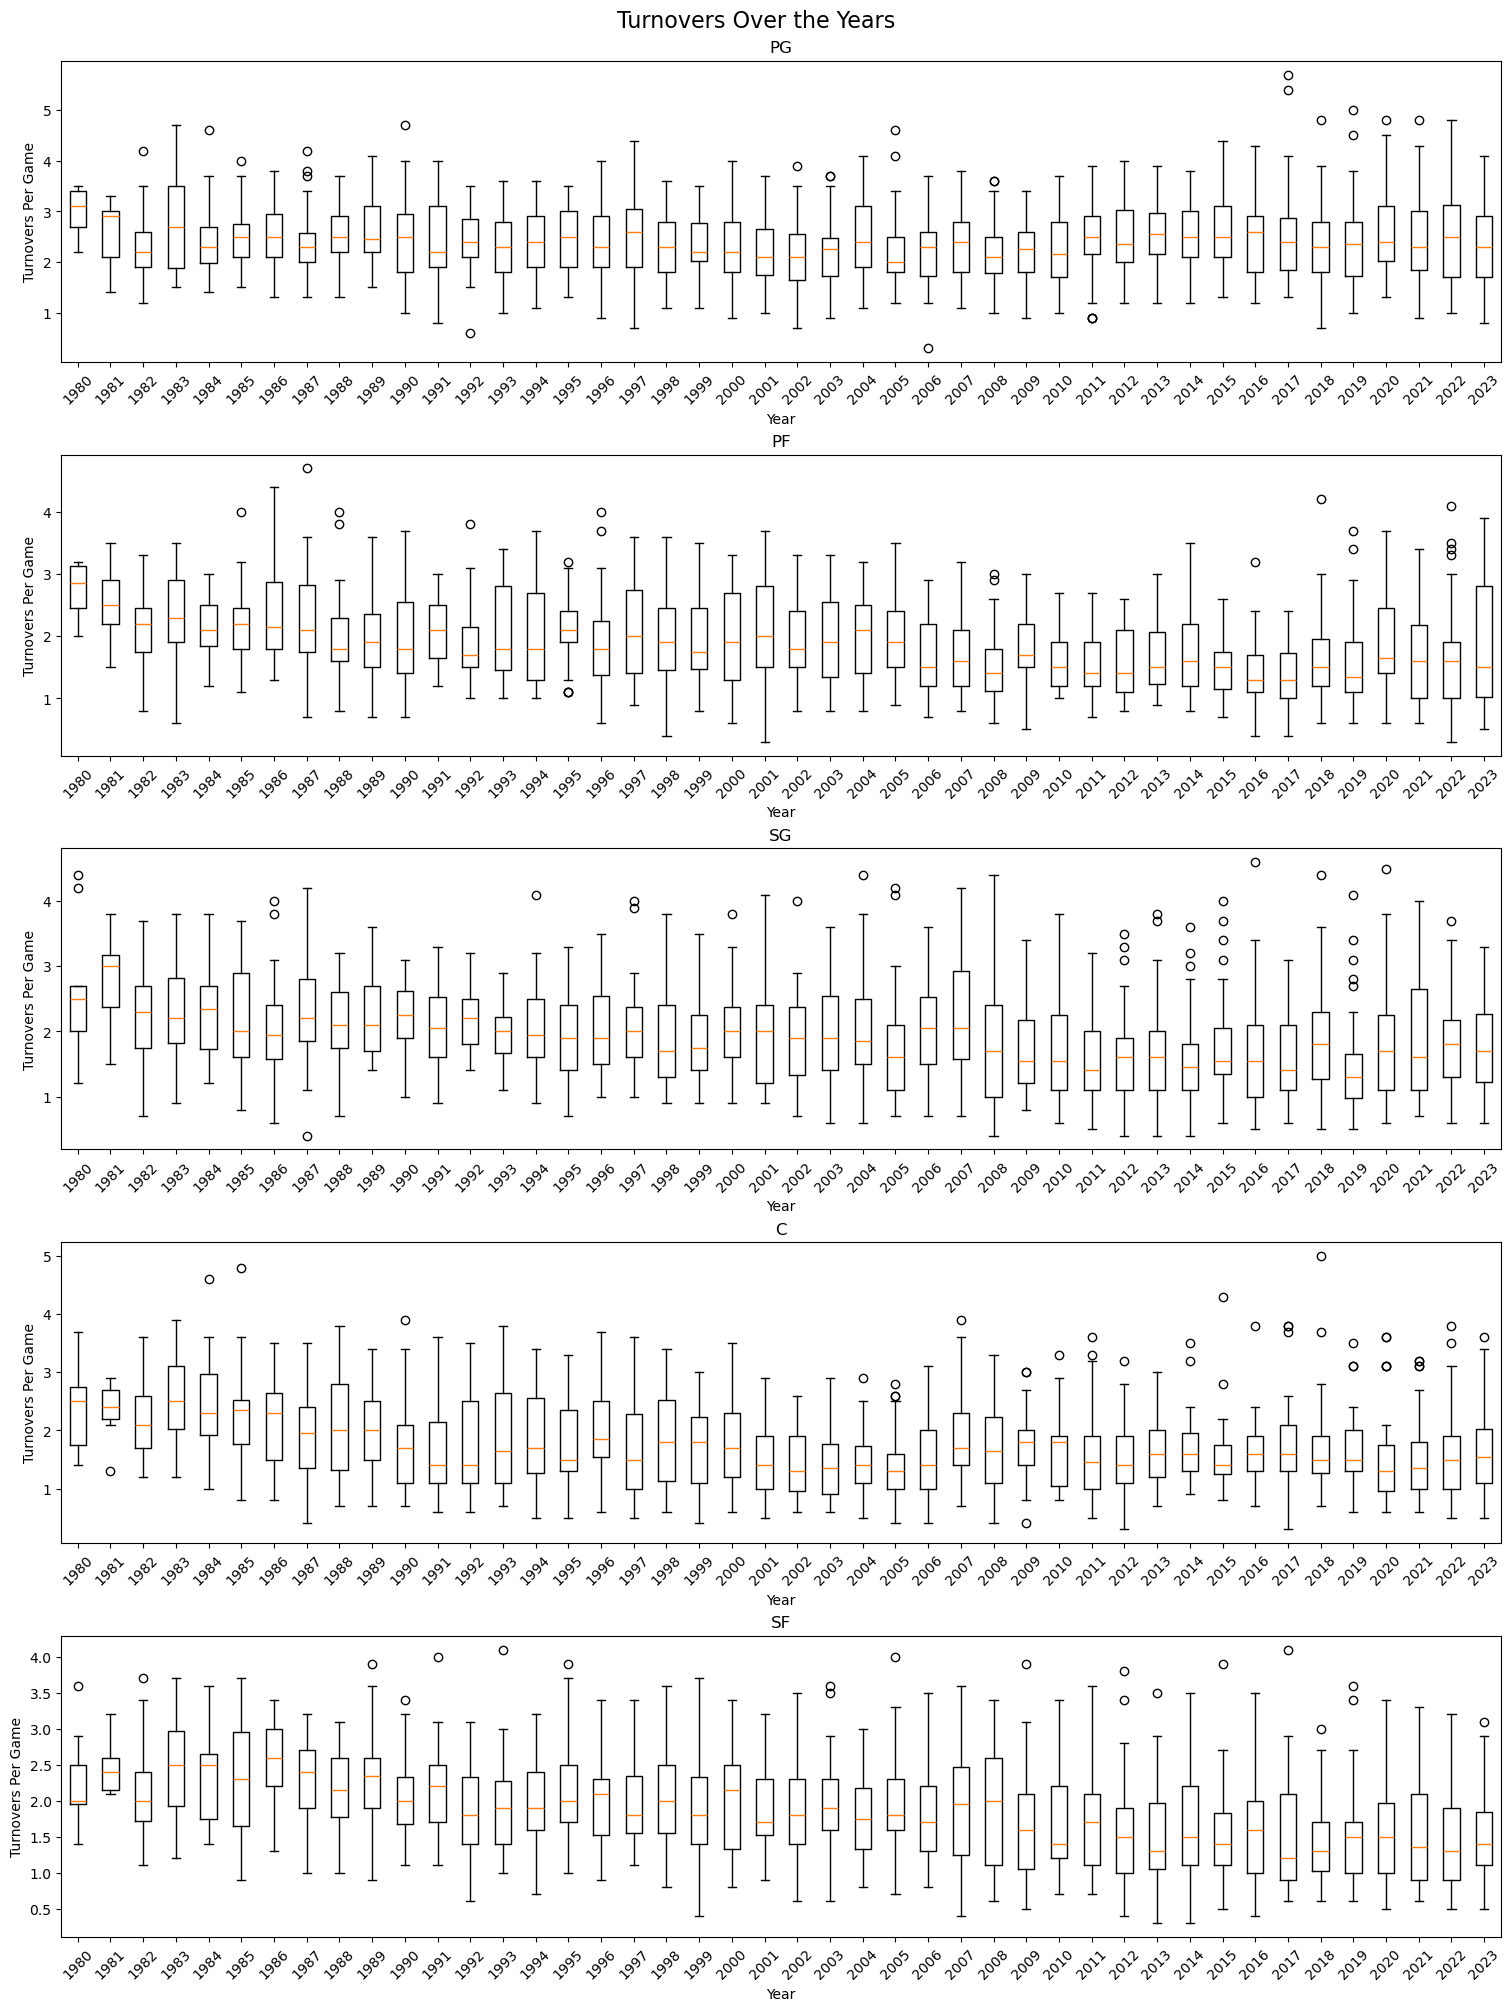

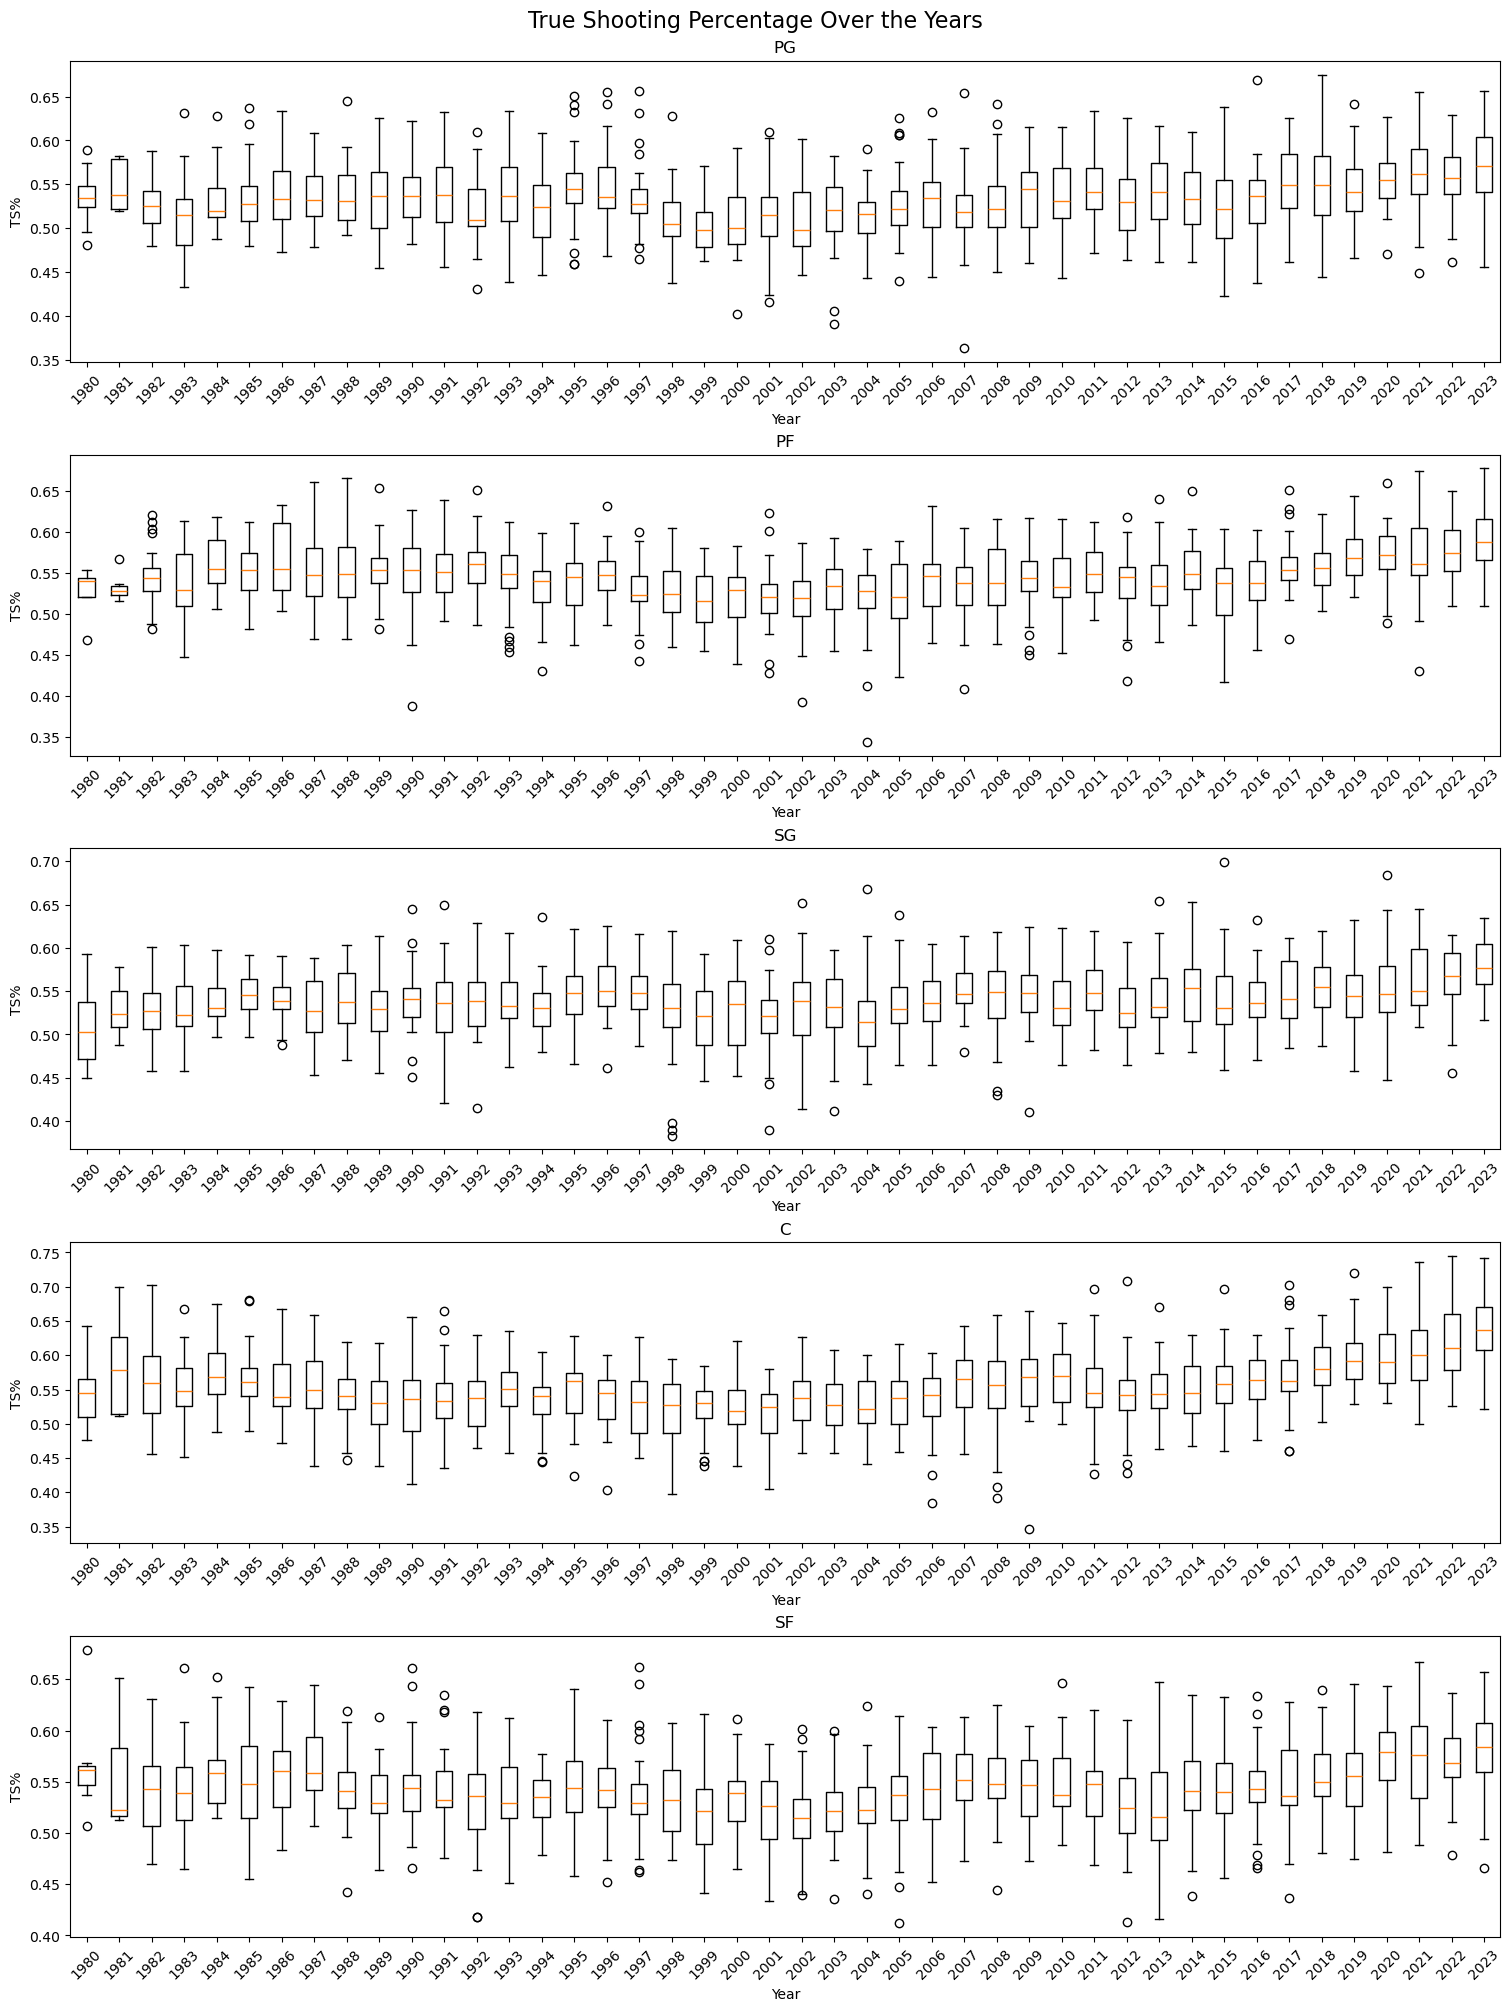

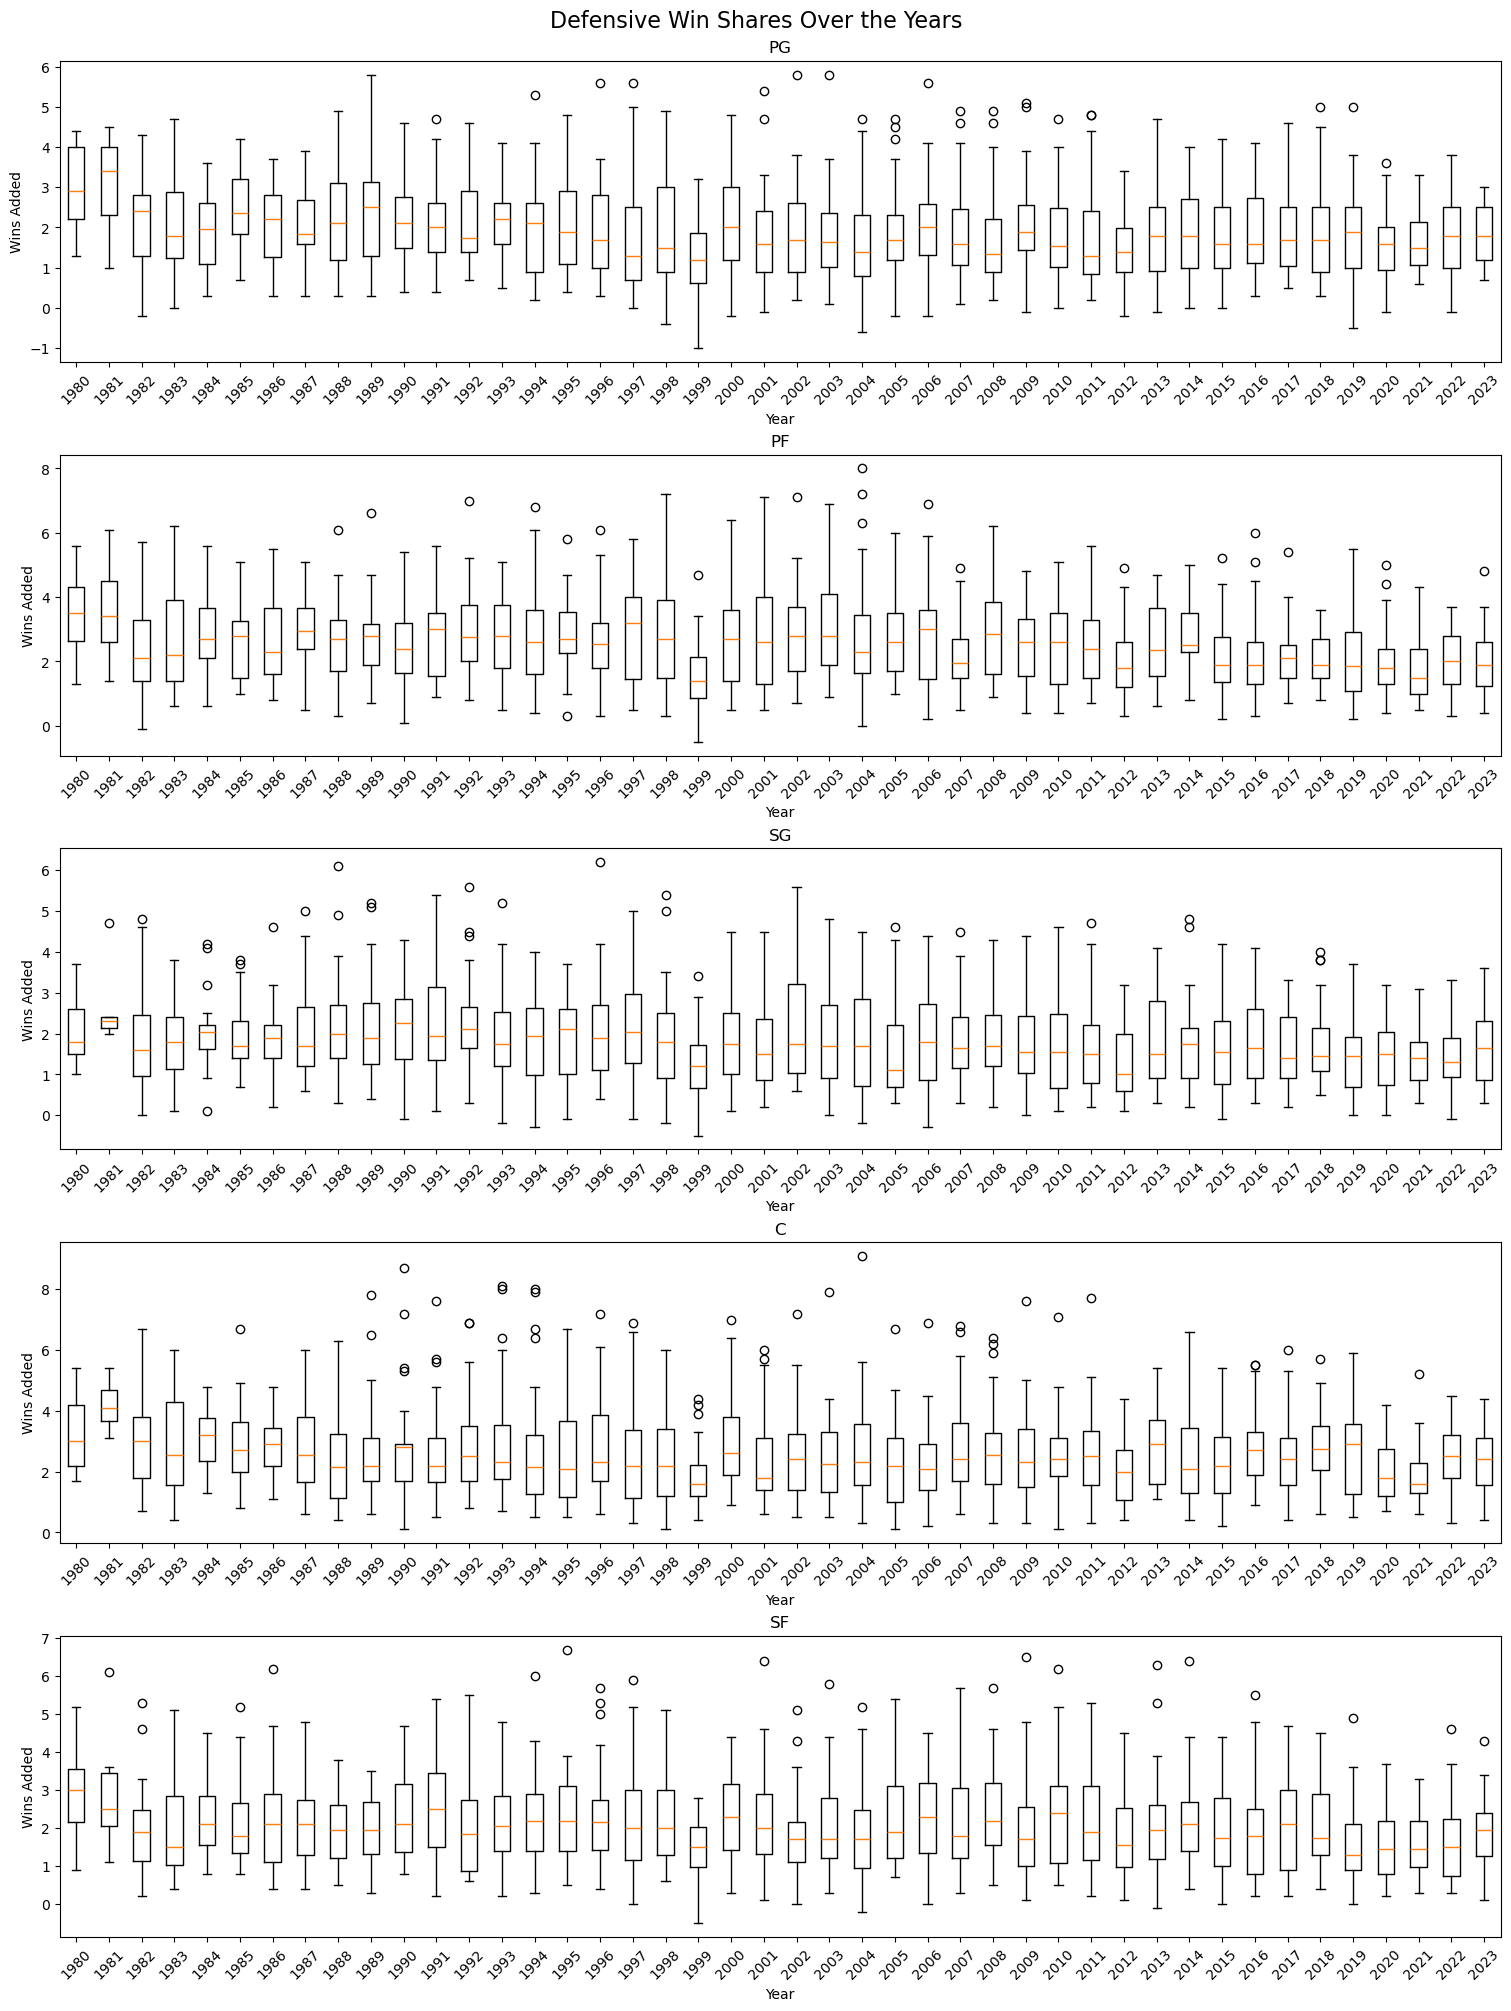

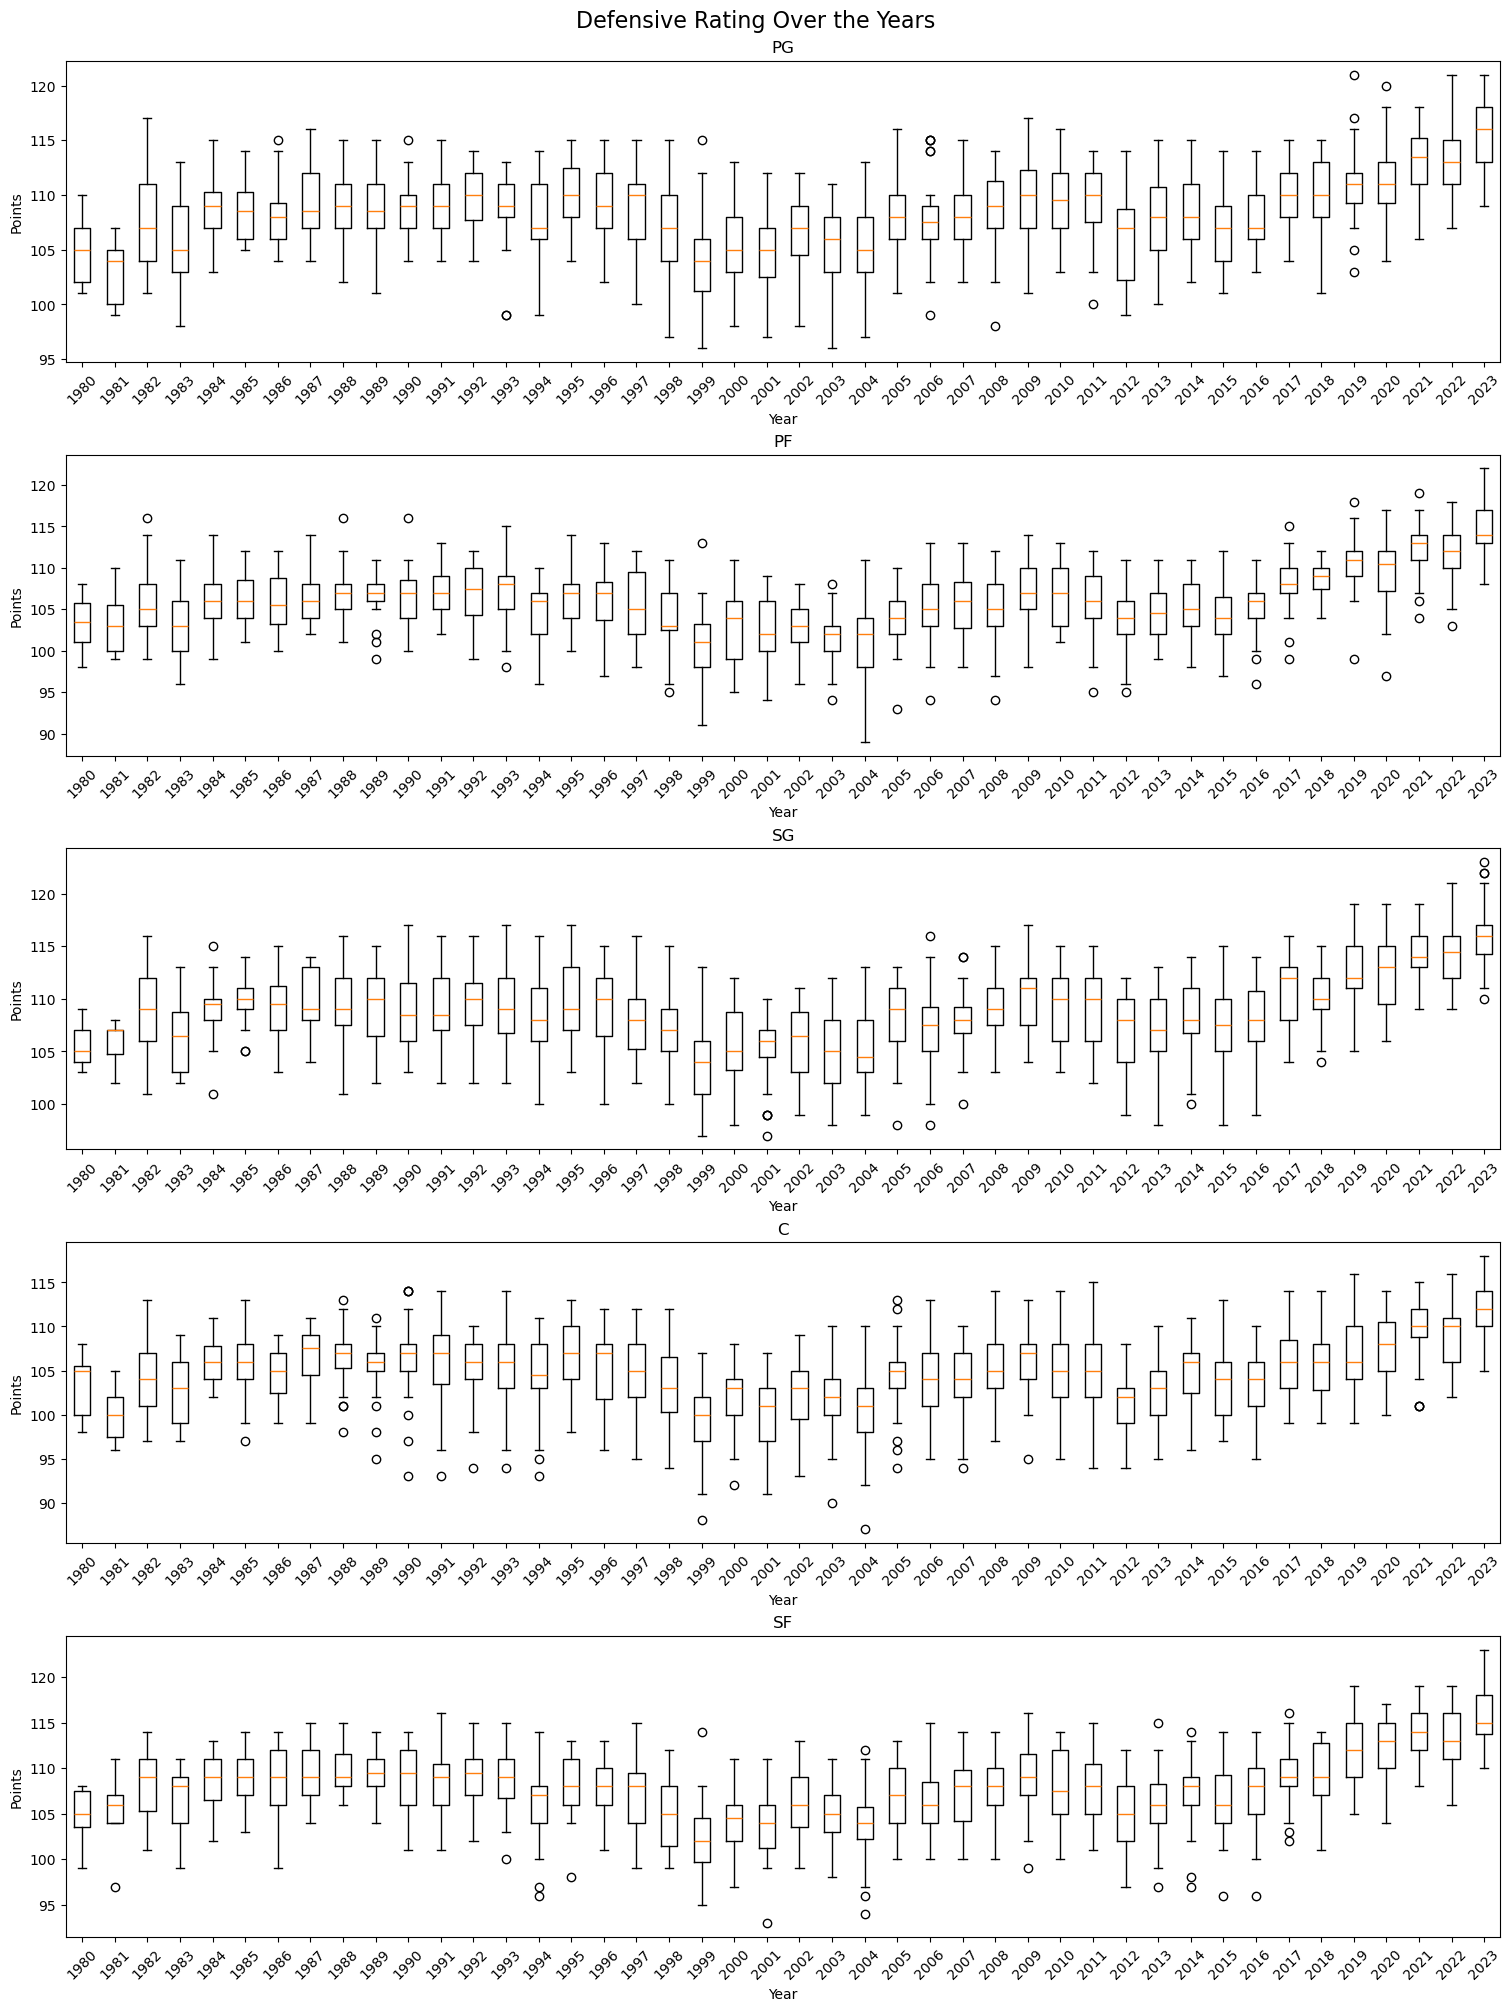

In [8]:
positionChart(starters, "PTS", "Scoring", "Points Per Game")
positionChart(starters, "TRB", "Rebounding", "Rebounds Per Game")
positionChart(starters, "AST", "Assists", "Assists Per Game")
positionChart(starters, "STL", "Steals", "Steals Per Game")
positionChart(starters, "BLK", "Blocks", "Blocks Per Game")
positionChart(starters, "TOV", "Turnovers", "Turnovers Per Game")
positionChart(starters, "TS%", "True Shooting Percentage", "TS%")
positionChart(starters, "DWS", "Defensive Win Shares", "Wins Added")
positionChart(starters, "DRtg", "Defensive Rating", "Points")

In [9]:
starters = starters.drop(columns=(starters.loc[:, "FG%":"DRB"] + starters.loc[:, "GS":"FGA"] + starters.loc[:, "3P":"3PA"] + starters.loc[:, "3PAr":"TOV%"] + starters.loc[:, "WS":"C%"] + starters.loc[:, "2P":"2P%"]))
starters = starters.drop(columns=["OWS", "TOV", "PF", "PER", "USG%", "DWS"])

In [10]:
starters["PTSZ"] = starters.groupby(["Pos", "Year"])["PTS"].transform(stats.zscore)
starters["ASTZ"] = starters.groupby(["Pos", "Year"])["AST"].transform(stats.zscore)
starters["BLKZ"] = starters.groupby(["Pos", "Year"])["BLK"].transform(stats.zscore)
starters["STLZ"] = starters.groupby(["Pos", "Year"])["STL"].transform(stats.zscore)
#starters["TOV_ZSCORE"] = starters.groupby(["Pos", "Year"])["TOV"].transform(stats.zscore) * -1
starters["TRBZ"] = starters.groupby(["Pos", "Year"])["TRB"].transform(stats.zscore)
starters["TS%Z"] = starters.groupby(["Pos", "Year"])["TS%"].transform(stats.zscore)
#Defensive ratings are a measure of how many points a player allows per 100 possesions. High DRtg is bad
starters["DRtgZ"] = starters.groupby(["Pos", "Year"])["DRtg"].transform(stats.zscore) * -1

In [11]:
starters

,Year,Player,Pos,Age,Tm,G,TRB,AST,STL,BLK,PTS,TS%,DRtg,PTSZ,ASTZ,BLKZ,STLZ,TRBZ,TS%Z,DRtgZ
0,1980,Tiny Archibald,PG,31,BOS,80,2.5,8.4,1.3,0.1,14.1,0.574,105.0,-0.630432,1.577593,-1.093216,-1.341065,-0.844583,1.189685,-0.035760
1,1980,Larry Bird,PF,23,BOS,82,10.4,4.5,1.7,0.6,21.3,0.538,98.0,1.111960,1.610954,-0.488813,1.732051,0.950654,0.389407,1.419048
2,1980,Ron Brewer,SG,24,POR,82,2.6,2.6,1.2,0.6,15.7,0.503,107.0,0.226937,-0.844652,1.988893,-0.550000,-0.377608,-0.210030,-0.811107
3,1980,Bill Cartwright,C,22,NYK,82,8.9,2.0,0.6,1.2,21.7,0.608,108.0,1.011212,-0.681442,0.127057,-0.957427,-0.267118,1.287452,-1.403512
4,1980,Maurice Cheeks,PG,23,PHI,79,3.5,7.0,2.3,0.4,11.4,0.589,101.0,-1.445300,0.380143,1.015129,0.853405,0.443764,1.653868,1.251597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7135,2023,Robert Williams,C,25,BOS,35,8.3,1.4,0.6,1.4,8.0,0.742,107.0,-1.045001,-0.555064,0.363521,-0.413175,-0.203454,1.991505,1.585472
7136,2023,Zion Williamson,PF,22,NOP,29,7.0,4.6,1.1,0.6,26.0,0.652,112.0,1.310210,0.853026,-0.007336,0.833476,0.446832,1.542391,0.897235
7137,2023,James Wiseman,C,21,DET,24,8.1,0.7,0.2,0.8,12.7,0.563,118.0,-0.211837,-0.956661,-0.554847,-1.950571,-0.300917,-1.481261,-1.937799
7138,2023,Trae Young,PG,24,ATL,73,3.0,10.2,1.1,0.1,26.2,0.573,119.0,1.120768,1.965644,-1.289317,-0.127685,-0.748418,0.051627,-1.301938


In [12]:
starters["AZS"] = starters.loc[:, "PTSZ":"DRtgZ"].mean(axis=1)
starters.sort_values("AZS", ascending=False).head(50)["Player"].value_counts()

Player
Hakeem Olajuwon          8
Michael Jordan           7
David Robinson           6
Dwyane Wade              5
LeBron James             4
James Harden             4
Magic Johnson            3
Kevin Durant             3
Giannis Antetokounmpo    2
Scottie Pippen           2
Larry Bird               1
Draymond Green           1
Shaquille O'Neal         1
Paul Millsap             1
Dwight Howard            1
Chris Paul               1
Name: count, dtype: int64

In [15]:
starters.sort_values("AZS", ascending=False).head(50)

,Year,Player,Pos,Age,Tm,G,TRB,AST,STL,BLK,...,TS%,DRtg,PTSZ,ASTZ,BLKZ,STLZ,TRBZ,TS%Z,DRtgZ,AZS
6175,2019,Giannis Antetokounmpo,PF,24,MIL,72,12.5,5.9,1.3,1.5,...,0.644,99.0,2.441825,2.707217,2.704507,1.910410,3.001977,2.339537,3.370416,2.639413
394,1984,Magic Johnson,PG,24,LAL,67,7.3,13.1,2.2,0.7,...,0.628,105.0,1.511602,2.498379,3.208445,1.254227,4.298256,2.996295,1.327788,2.442142
1226,1990,Hakeem Olajuwon,C,27,HOU,82,14.0,2.9,2.1,4.6,...,0.541,93.0,2.088100,2.088095,3.058527,3.612712,2.604576,0.207789,3.202919,2.408960
1542,1992,David Robinson,C,26,SAS,68,12.2,2.7,2.3,4.5,...,0.597,94.0,1.911430,1.642017,2.580521,3.673266,1.819023,1.661048,3.115735,2.343291
1373,1991,Hakeem Olajuwon,C,28,HOU,56,13.8,2.3,2.2,3.9,...,0.549,93.0,1.815636,1.415487,2.862640,3.935226,2.467379,0.270221,3.131034,2.271089
4520,2009,Dwyane Wade,SG,27,MIA,79,5.0,7.5,2.2,1.3,...,0.574,105.0,2.491936,2.945833,3.544931,3.274785,1.395539,0.780597,1.452109,2.269390
1390,1991,David Robinson,C,25,SAS,82,13.0,2.5,1.5,3.9,...,0.615,96.0,2.615953,1.719641,2.862640,2.079757,2.141460,1.626064,2.409910,2.207918
4433,2009,LeBron James,SF,24,CLE,81,7.6,7.2,1.7,1.1,...,0.591,99.0,2.407305,3.355693,1.775000,1.964406,1.661375,1.360109,2.804227,2.189731
5013,2012,LeBron James,SF,27,MIA,62,7.9,6.2,1.9,0.8,...,0.605,97.0,2.684309,3.026839,1.079623,2.366757,2.159972,1.977304,2.022859,2.188238
1075,1989,Hakeem Olajuwon,C,26,HOU,82,13.5,1.8,2.6,3.4,...,0.552,95.0,2.330149,0.459302,2.207276,4.090904,2.398385,0.349693,3.381106,2.173831


In [16]:
starters["AZS"] = starters.loc[:, "PTSZ":"DRtgZ"].mean(axis=1)
starters.sort_values("AZS", ascending=False).head(50)["Pos"].value_counts()

Pos
SG    18
C     16
SF     9
PF     5
PG     2
Name: count, dtype: int64

In [17]:
starters[starters["Player"] == "Tim Duncan"]

,Year,Player,Pos,Age,Tm,G,TRB,AST,STL,BLK,...,TS%,DRtg,PTSZ,ASTZ,BLKZ,STLZ,TRBZ,TS%Z,DRtgZ,AZS
2453,1998,Tim Duncan,PF,21,SAS,82,11.9,2.7,0.7,2.5,...,0.577,95.0,1.483496,0.494271,3.346789,-0.951822,1.693402,1.347073,2.131796,1.363572
2631,1999,Tim Duncan,PF,22,SAS,50,11.4,2.4,0.9,2.5,...,0.541,91.0,1.702221,0.539850,2.572285,0.204376,1.526528,0.572049,2.463326,1.368662
2785,2000,Tim Duncan,PF,23,SAS,74,12.4,3.2,0.9,2.2,...,0.555,95.0,1.556041,0.936240,2.404671,0.082052,2.427935,1.035298,1.850501,1.470391
2942,2001,Tim Duncan,PF,24,SAS,82,12.2,3.0,0.9,2.3,...,0.536,94.0,1.160053,0.525143,2.405774,0.163332,1.836740,0.392457,2.266244,1.249963
3122,2002,Tim Duncan,PF,25,SAS,82,12.7,3.7,0.7,2.5,...,0.576,96.0,2.068310,1.158709,2.224742,-0.585076,2.118375,1.525105,2.418871,1.561291
3296,2003,Tim Duncan,PF,26,SAS,81,12.9,3.9,0.7,2.9,...,0.564,94.0,1.518056,1.120155,2.908816,-0.816273,2.174333,0.962062,2.322421,1.455653
3469,2004,Tim Duncan,PF,27,SAS,69,12.4,3.1,0.9,2.7,...,0.534,89.0,1.620563,0.750950,2.197057,-0.149214,1.950215,0.302300,2.475447,1.306760
3657,2005,Tim Duncan,PF,28,SAS,66,11.1,2.7,0.7,2.6,...,0.540,93.0,0.990199,0.354353,2.704459,-0.635176,1.372306,0.348982,3.246079,1.197315
3846,2006,Tim Duncan,PF,29,SAS,80,11.0,3.2,0.9,2.0,...,0.523,94.0,0.867979,0.867637,1.901084,0.402492,1.430736,-0.442048,2.621645,1.092789
4027,2007,Tim Duncan,C,30,SAS,80,10.6,3.4,0.8,2.4,...,0.579,94.0,1.447906,2.145793,1.524193,0.631916,1.198386,0.419141,2.428417,1.399393


The first two charts above show the top 50 seasons since 1985 in terms of average z-score and which players are most represented in the top 50 list respectively. A few things to take note of are that the best season to date is Giannis Antetokounpo's 2019 season and the player that shows up most on the top 50 seasons list is Hakeem Olajuwon. On the list of the most represented players are many familiar names to the GOAT conversation; Michael Jordan shows up in second with 7 appearances; LeBron James is tied in 5th place with James Harden with 4 appearances; Shaquille O'Neal has two appearances giving him a 3-way tie with Scottie Pippen and Giannis Antetokounpo. There are also some surprises on this list. Namely Shawn Marion, Paul Milsap, and Draymond Green sneaking on the list with one appearance each. Finally, there are some notable absences from this list. Frequently mentioned all-time greats Magic Johnson and Stephen Curry do not make the top 50 even once. There is only one top 50 season logged by a point guard, Chris Paul in 2009. 5-time champion Kobe Bryant also does not make an appearance. I suspect that the metric favors well-rounded players above all else. Specialists, players with deficiencies, and players who perform about average in some areas are overlooked using this metric.

The ultimate goal of this project is to be able to compare the careers of NBA players who did not play at the same time and may not play the same position. To do this, we need to take the average of all seasons played by each player. The chart below shows the best 10 players of all time according to their average z-score and the graphs display the top 10 players' career trajectory by year, age, and NBA experience. These graphs show a few interesting trends.

In [18]:
temp = starters.drop(columns=["Pos", "Tm"])
topten = temp.groupby("Player").mean().sort_values("AZS", ascending=False).head(10)
topten

,Year,Age,G,TRB,AST,STL,BLK,PTS,TS%,DRtg,PTSZ,ASTZ,BLKZ,STLZ,TRBZ,TS%Z,DRtgZ,AZS
Player,,,,,,,,,,,,,,,,,,
Giannis Antetokounmpo,2019.000000,24.000000,71.333333,10.411111,5.111111,1.177778,1.288889,25.077778,0.604778,103.777778,1.744614,1.523868,2.124588,0.739359,2.666348,1.166727,1.888342,1.693407
Magic Johnson,1986.500000,26.500000,76.000000,7.160000,11.920000,1.830000,0.380000,19.780000,0.612100,105.200000,1.423602,2.483323,1.053628,0.599309,2.880157,2.012159,1.093152,1.649333
Michael Jordan,1993.153846,29.153846,79.769231,6.253846,5.300000,2.346154,0.807692,30.169231,0.566615,102.846154,2.615980,1.249304,1.485442,1.834788,1.710245,0.825819,1.673023,1.627800
James Harden,2018.785714,28.785714,62.928571,6.671429,8.914286,1.542857,0.614286,26.664286,0.607071,108.642857,1.897346,2.466099,1.283494,1.239006,2.028288,1.331793,0.898166,1.592028
David Robinson,1996.461538,30.461538,75.461538,10.584615,2.453846,1.400000,2.969231,20.707692,0.577769,95.076923,1.516678,1.190398,1.566084,1.989557,1.231306,1.081073,2.134115,1.529888
LeBron James,2013.500000,28.500000,71.050000,7.540000,7.340000,1.515000,0.745000,27.200000,0.589350,104.500000,2.116010,3.030000,0.656565,1.300018,1.381772,1.072515,1.051202,1.515440
Hakeem Olajuwon,1993.500000,30.500000,68.777778,10.838889,2.405556,1.716667,2.994444,21.005556,0.545944,98.000000,1.534505,1.079104,1.548591,2.873457,1.301346,0.218726,1.697768,1.464785
Larry Bird,1985.750000,28.750000,74.250000,9.975000,6.400000,1.700000,0.841667,24.133333,0.562000,101.583333,1.426098,2.850564,0.407759,1.777972,1.805053,0.429544,1.553503,1.464356
Dwyane Wade,2010.500000,28.500000,65.357143,4.742857,5.614286,1.642857,0.864286,23.064286,0.556714,104.214286,1.527151,1.642880,2.679780,1.528820,1.056177,0.487822,1.129448,1.436011


The chart above shows the top 10 players in the three-point era (since 1980) by average z-score. On the list are a lot of your typical names like Michael Jordan, LeBron James, Magic Johnson, and Larry Bird. But there are also some surprising names like Giannis Antetokounpo ranking as the best player in the three-point era. 

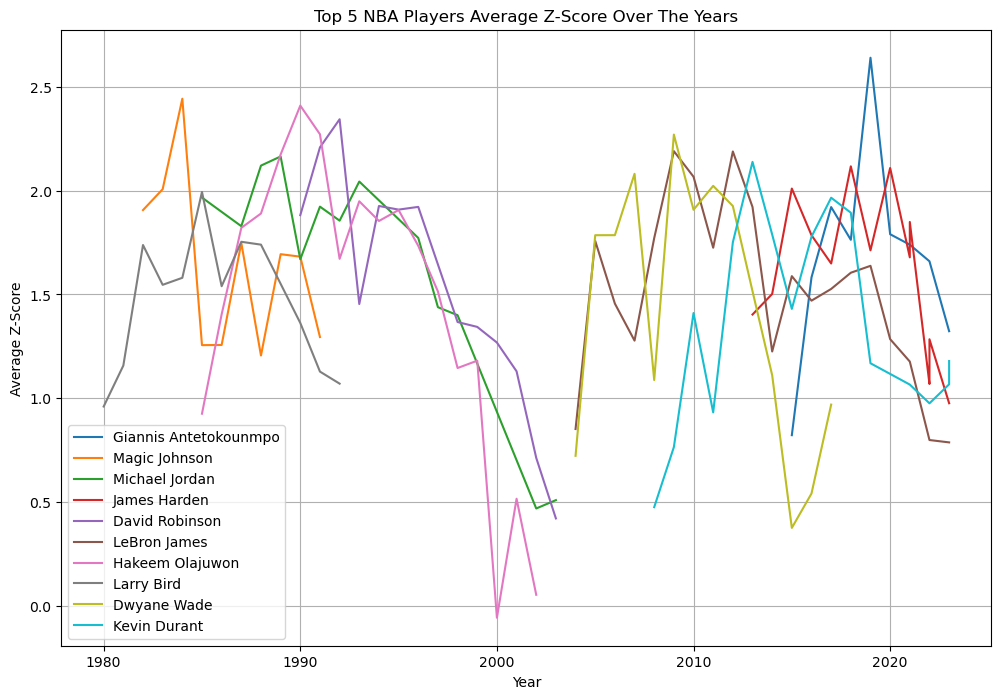

In [25]:
fig, ax = plt.subplots(figsize=(12,8))
for entry in topten.iterrows():
    player = starters[starters["Player"] == entry[0]]
    line, = plt.plot(player["Year"], player["AZS"], '-', label=entry[0])
plt.xlabel('Year')
plt.ylabel("Average Z-Score")
plt.title('Top 5 NBA Players Average Z-Score Over The Years')
plt.grid(True)
plt.legend()
plt.show()

This graph tracks the top 10 players from the start of the three-point era to today. There are two interesting things that this graph shows. The first is that basketball around the turn of the millennium was about to lose some of its biggest stars: David Robinson, Michael Jordan, and Hakeem Olajuwon. They'd been declining for the last few years and would retire in 2002 and 2003. Luckily for the NBA, the 2003 draft is argued to be the greatest draft class ever giving rise to two top 10 players, Dwyane Wade and LeBron James. In the decades to come, they would be joined by several more stars that have defined a generation of basketball, but in 2024, the basketball landscape looks similar to how it did in the early 2000s. The stars that had dominated the past 20 years or so of basketball are all in their twilight years, except Giannis Antetokounpo, who is still just 29 years old. Giannis should still have a few more years of performing at a high level left, but time will tell if any younger players can make their way onto this list.

In [28]:
starters[starters["Player"] == "Kevin Durant"]

,Year,Player,Pos,Age,Tm,G,TRB,AST,STL,BLK,...,DRtg,PTSZ,ASTZ,BLKZ,STLZ,TRBZ,TS%Z,DRtgZ,AZS,Experience
4202,2008,Kevin Durant,SG,19,SEA,80,4.4,2.4,1.0,0.9,...,110.0,0.726914,-0.500826,3.328921,-0.105099,6.264179e-01,-0.397289,-0.343978,0.476437,1.0
4394,2009,Kevin Durant,SF,20,OKC,74,6.5,2.8,1.3,0.7,...,109.0,1.892262,0.257669,0.450794,0.821037,9.485695e-01,0.958064,0.029518,0.765416,2.0
4589,2010,Kevin Durant,SF,21,OKC,82,7.6,2.8,1.4,1.0,...,104.0,2.688725,0.325481,1.645906,0.888919,1.607031e+00,1.677027,1.041875,1.410709,3.0
4785,2011,Kevin Durant,SF,22,OKC,78,6.8,2.7,1.1,1.0,...,107.0,2.292525,0.097138,1.025324,0.295769,1.181573e+00,1.427475,0.208168,0.932568,4.0
4970,2012,Kevin Durant,SF,23,OKC,66,8.0,3.5,1.3,1.2,...,101.0,2.846449,0.893345,2.455426,0.717662,2.228302e+00,2.100928,1.014929,1.751006,5.0
5143,2013,Kevin Durant,SF,24,OKC,81,7.9,4.6,1.4,1.3,...,100.0,3.185754,1.922241,2.788581,1.040959,2.071473e+00,2.332590,1.625057,2.138093,6.0
5324,2014,Kevin Durant,SF,25,OKC,81,7.4,5.5,1.3,0.7,...,104.0,3.331636,2.588583,0.972864,0.632097,1.680617e+00,2.463552,0.850874,1.788603,7.0
5501,2015,Kevin Durant,SF,26,OKC,27,6.6,4.1,0.9,0.9,...,105.0,2.415218,1.267848,2.188121,-0.106336,1.306896e+00,2.513154,0.429500,1.430629,8.0
5687,2016,Kevin Durant,SF,27,OKC,72,8.2,5.0,1.0,1.2,...,104.0,2.397269,1.719524,3.039459,-0.076898,2.050499e+00,2.438464,0.876759,1.777868,9.0
5869,2017,Kevin Durant,PF,28,GSW,62,8.3,4.8,1.1,1.6,...,101.0,2.418286,2.142968,1.845411,0.956850,1.167389e+00,2.821684,2.406688,1.965611,10.0


Text(0.5, 1.0, 'Top 5 NBA Players Average Z-Score By Age')

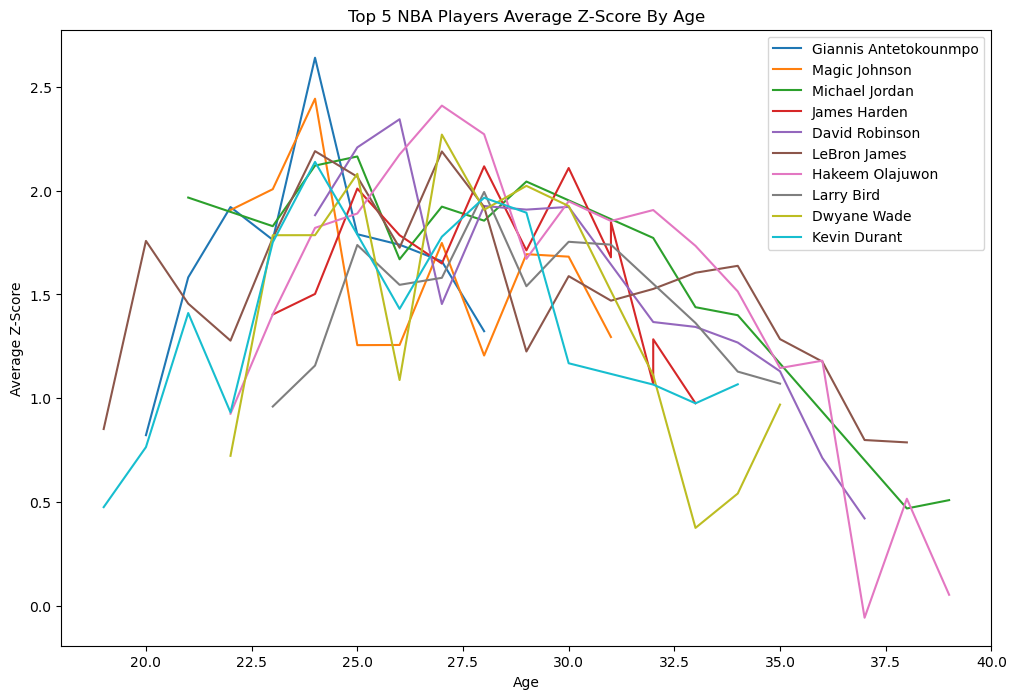

In [29]:
starters = starters.drop(index=7000) #deleting Kevin Durant's 39 game stint with BKN because it is included in his total stats for the year
fig, ax = plt.subplots(figsize=(12,8))
for entry in topten.iterrows():
    player = starters[starters["Player"] == entry[0]]
    line, = plt.plot(player["Age"], player["AZS"], '-', label=entry[0])
plt.legend()
plt.xlabel('Age')
plt.ylabel("Average Z-Score")
plt.title('Top 5 NBA Players Average Z-Score By Age')

In [30]:
starters["Experience"] = starters.groupby("Player")["Year"].rank()

Text(0.5, 1.0, 'Top 5 NBA Players Average Z-Score By Experience')

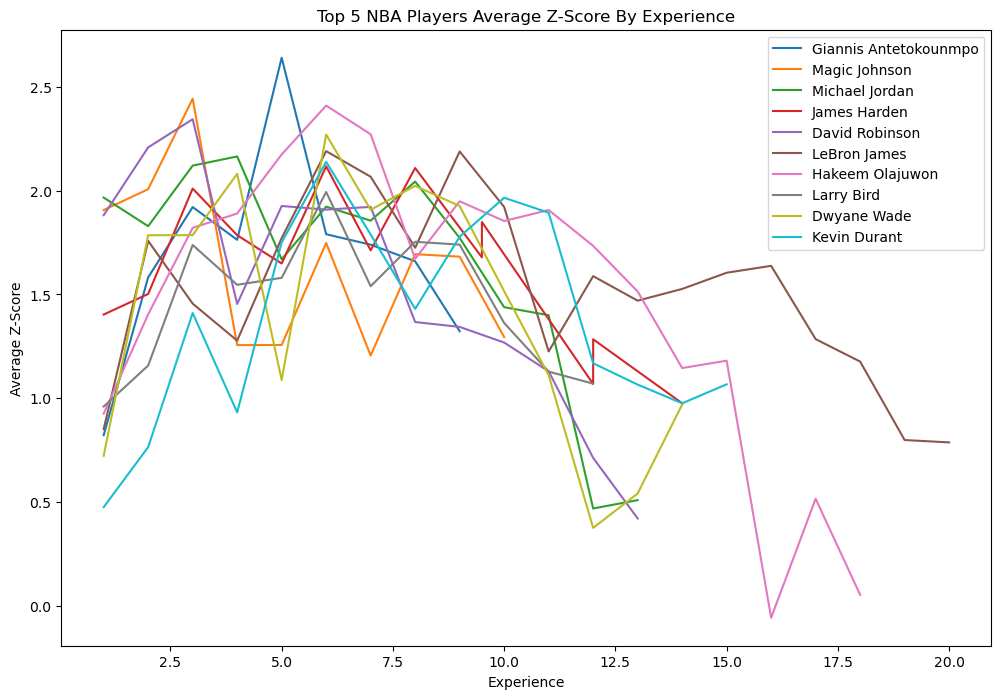

In [31]:
fig, ax = plt.subplots(figsize=(12,8))
for entry in topten.iterrows():
    player = starters[starters["Player"] == entry[0]]
    line, = plt.plot(player["Experience"], player["AZS"], '-', label=entry[0])
plt.legend()
plt.xlabel('Experience')
plt.ylabel("Average Z-Score")
plt.title('Top 5 NBA Players Average Z-Score By Experience')

These two graphs are interesting because they show that the NBA's greatest players all have a similar career trajectory, peaking somewhere between their 5th and 8th season, or in their mid to late 20s, before declining in the latter half of their career. For some, like Dwyane Wade and Hakeem Olajuwon, this decline can come fast. For others, like LeBron James, they can have long-lived careers while still being more productive than their peers.

In [32]:
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

I thought the best way to view the Z-score data would be to create spider graphs for each of the top 10 players. The spider graphs give a sense of how these players achieved their average z-score and allow you to compare the variables between players more easily. 

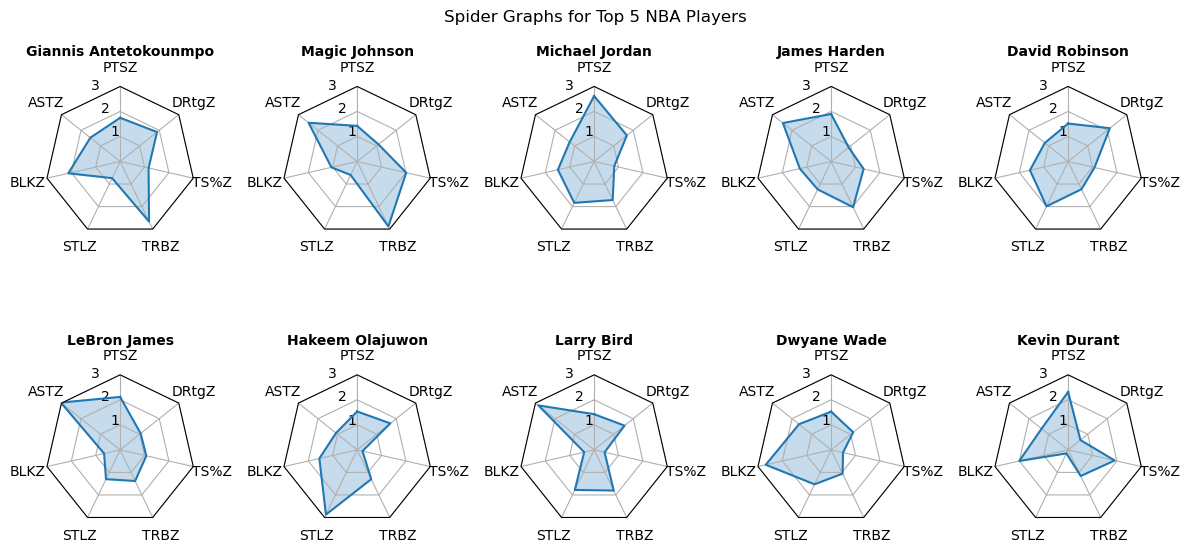

In [35]:
N = 7
theta = radar_factory(N, frame='polygon')
data = []
data.append(["PTSZ", "ASTZ", "BLKZ", "STLZ", "TRBZ", "TS%Z", "DRtgZ"])
for entry in topten.iterrows():
    data.append((entry[0], entry[1].loc["PTSZ":"DRtgZ"].values))
spoke_labels = data.pop(0)

fig, axs = plt.subplots(2, 5, figsize=(12, 6), subplot_kw=dict(projection='radar'))
count = 0
for (title, case_data), ax in zip(data, axs.flatten()):
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                    horizontalalignment='center', verticalalignment='center')
    ax.plot(theta, case_data)
    ax.fill(theta, case_data, alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)
    ax.set_ylim(0, 3)
    count+=1
plt.tight_layout()
fig.suptitle("Spider Graphs for Top 5 NBA Players")
plt.show()

In [36]:
#Extract MVP and All-Star Game Status from Basketball-Reference
asg = pd.DataFrame()
mvp = pd.DataFrame(columns=["Player", "MVP", "Year"])
for year in np.arange(1985, 2023):
    req = requests.get(f"https://www.basketball-reference.com/leagues/NBA_{year}_per_game.html")
    if (req.status_code != 200):
        print(str(req.status_code) + f" on https://www.basketball-reference.com/leagues/NBA_{year}_per_game.html")
    soup = bs(req.content)
    y = soup.find(string="Most Valuable Player")
    mvp.loc[len(mvp.index)] = [y.parent.parent.find('a').text, 1, year]
    print(y.parent.parent.find('a').text)
    time.sleep(4)
    req = requests.get(f"https://www.basketball-reference.com/allstar/NBA_{year}.html")
    if (req.status_code != 200):
        print(str(req.status_code) + f" on https://www.basketball-reference.com/allstar/NBA_{year}.html")
    soup = bs(req.content)
    tables = soup.findAll('table')
    if tables:
        result = pd.read_html(str(tables[0]))[0]
        team1 = pd.read_html(str(tables[1]))[0]
        team2 = pd.read_html(str(tables[2]))[0]
        df = pd.concat([team1, team2], ignore_index=True)
        df["Year"] = year
        if asg.shape[0] == 0:
            asg = df
        else:
            asg = pd.concat([asg, df], ignore_index=True)
        #print(result.iloc[0][('Unnamed: 0_level_0', 'Unnamed: 0_level_1')] + ": " + str(result.iloc[0][('Scoring', 'T')]) + "\n" +
        #result.iloc[1][('Unnamed: 0_level_0', 'Unnamed: 0_level_1')] + ": " + str(result.iloc[1][('Scoring', 'T')]))
    time.sleep(4)
asg = asg[(asg["Totals", "FG"] != "FG") & (asg["Totals", "FG"] != "Totals") & (asg['Unnamed: 0_level_0', 'Starters'] != "Team Totals")]
asg['ASG'] = 1
asg = asg.drop(columns=df.columns.difference([('ASG', ''), ('Unnamed: 0_level_0', 'Starters'), ('Year', '')]))
asg.columns = ["Player", "Year", "ASG"]
starters = starters.merge(mvp, "left")
starters = starters.merge(asg, "left")
starters["ASG"] = starters["ASG"].fillna(0)
starters["MVP"] = starters["MVP"].fillna(0)

#
x = starters.loc[:, "PTSZ":"DRtgZ"]
y1 = starters["ASG"]
y2 = starters["MVP"]

Larry Bird
Larry Bird
Magic Johnson
Michael Jordan
Magic Johnson
Magic Johnson
Michael Jordan
Michael Jordan
Charles Barkley
Hakeem Olajuwon
David Robinson
Michael Jordan
Karl Malone
Michael Jordan
Karl Malone
404 on https://www.basketball-reference.com/allstar/NBA_1999.html
Shaquille O'Neal
Allen Iverson
Tim Duncan
Tim Duncan
Kevin Garnett
Steve Nash
Steve Nash
Dirk Nowitzki
Kobe Bryant
LeBron James
LeBron James
Derrick Rose
LeBron James
LeBron James
Kevin Durant
Stephen Curry
Stephen Curry
Russell Westbrook
James Harden
Giannis Antetokounmpo
Giannis Antetokounmpo
Nikola Jokić
Nikola Jokić


For the last part of this project, I wanted to see if these z-scores I've calculated can be used to classify seasons as either All-Star or MVP caliber. To do this, I first started with a logistic regression, which is useful for binary classifications like we are dealing with. I created two logistic regressions, one for the All-Stars and one for the MVP. 20% of the data was randomly selected and set aside for testing.

In [89]:
X_train, X_test, y_train, y_test = train_test_split(x, y1, test_size=0.20)
logreg = LogisticRegression(random_state=16)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
conf = metrics.confusion_matrix(y_test, y_pred)
print(conf)

target_names = ['Not an All-Star', 'All-Star']
print(classification_report(y_test, y_pred, target_names=target_names))

[[1109   33]
 [  85  108]]
                 precision    recall  f1-score   support

Not an All-Star       0.93      0.97      0.95      1142
       All-Star       0.77      0.56      0.65       193

       accuracy                           0.91      1335
      macro avg       0.85      0.77      0.80      1335
   weighted avg       0.91      0.91      0.91      1335



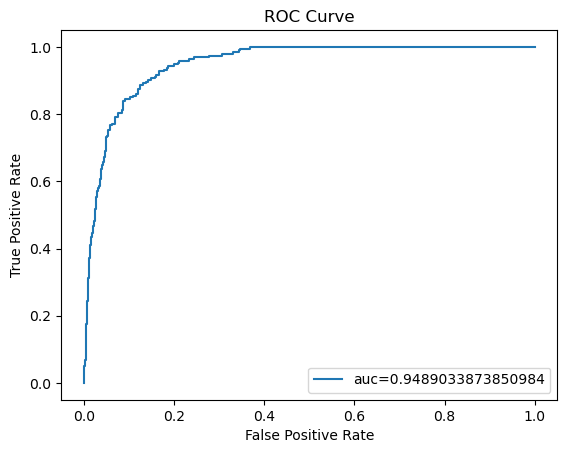

In [92]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

The data above is for the All-Star regression. I first want to detail a few definitions that will be useful in assessing the performance of the models. Precision is a measure of the quality of a model's predictions. In other words, if the model says a player is an All-Star, how often is the model correct? This metric exists for both the positive (All-Star) and negative (Not an All-Star) predictions. Recall is the percentage of observations belonging to each class that the model gets correct. In other words, of the All-Stars, how many did the model predict as All-Stars? The f1-score is the harmonic mean of the precision and recall of the model. It provides another measure of the model's accuracy. These metrics are provided by the classification report.

Overall, the model is very accurate, with an accuracy of 91% per the classification report, but this does not tell the whole story. The model is very good at handling non-All-Stars, with a precision and specificity of 0.93 and 0.97 respectively, thus it has a very high f1-score of 0.95. The model does not handle All-Star observations as well with significantly lower precision and recall scores of 0.77 and 0.56. The f1-score for All-Stars is 0.65, which while not great, is still acceptable. I suspect that these results arise from the fact that only around 15% of the players in the data set are all-stars.

Another metric is the area under the receiver operating characteristic curve or AUC-ROC. The ROC, or receiver operating characteristic plots the relationship between false positive and true positive rate. The area under this curve is 0.5 for a classifier that randomly guesses and 1 for a perfect classifier. I suspect that this metric is high because of the scarcity of All-Stars in the dataset.

[[1325    1]
 [   7    2]]
              precision    recall  f1-score   support

  Not an MVP       0.99      1.00      1.00      1326
         MVP       0.67      0.22      0.33         9

    accuracy                           0.99      1335
   macro avg       0.83      0.61      0.67      1335
weighted avg       0.99      0.99      0.99      1335



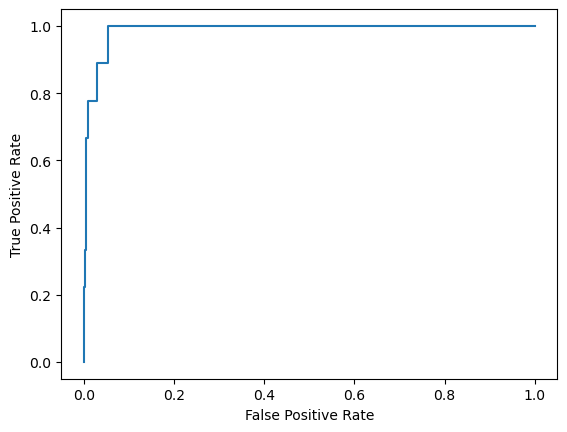

In [98]:
X_train, X_test, y_train, y_test = train_test_split(x, y2, test_size=0.20)
logreg = LogisticRegression(random_state=16)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(cnf_matrix)

target_names = ['Not an MVP', 'MVP']
print(classification_report(y_test, y_pred, target_names=target_names))
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

The data for the MVP logistic regression looks similar to the All-Star regression: very good f1-scores for non-MVPs and a high AUC score, but this time the model handles MVP observations even worse. I suspect this is because there are even fewer MVPs in the league than there are all-stars. The model's f1-score of 0.33 means the model performs worse than random guessing for MVPs.

After using the logistic regression for binary classification, I wanted to see if I could do any better with K-Nearest Neighbors classification. In this type of classification, predictions are determined by the labels of the nearest k, in this case 5, neighbors. Distance for this classifier is determined by normal Euclidean distance.

In [101]:
X_train, X_test, y_train, y_test = train_test_split(x, y1, test_size=0.20)
classifier = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(cnf_matrix)
target_names = ["Not and All-Star", "All-Star"]
print(classification_report(y_test, y_pred, target_names=target_names))

[[1093   70]
 [  80   92]]
                  precision    recall  f1-score   support

Not and All-Star       0.93      0.94      0.94      1163
        All-Star       0.57      0.53      0.55       172

        accuracy                           0.89      1335
       macro avg       0.75      0.74      0.74      1335
    weighted avg       0.88      0.89      0.89      1335



In [102]:
X_train, X_test, y_train, y_test = train_test_split(x, y2, test_size=0.20)
classifier = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(cnf_matrix)
target_names = ["Not and MVP", "MVP"]
print(classification_report(y_test, y_pred, target_names=target_names))

[[1325    2]
 [   7    1]]
              precision    recall  f1-score   support

 Not and MVP       0.99      1.00      1.00      1327
         MVP       0.33      0.12      0.18         8

    accuracy                           0.99      1335
   macro avg       0.66      0.56      0.59      1335
weighted avg       0.99      0.99      0.99      1335



In both cases, the KNN classifiers performed worse than the logistic regression. These classifiers probably performed worse because of the scarcity of positive observations in both cases. MVPs do not significantly outperform other players enough so that they are isolated in space and the same goes for MVPs, so the likelihood of being surrounded by a non-MVP or non-All-Star is high just due to the negative observations outnumbering the positive ones.

Takeaways and Future Directions

The main takeaway from this project is that it is hard to get a single metric to accurately capture all of an NBA's productivity and impact. If my metric alone, average Z-score was used to determine who the greatest NBA players are of all time, the top 5 list would be Giannis Antetokounpo, Michael Jordan, James Harden, David Robinson, and LeBron James in that order. Not only is this not a conventional top 5 list, but the stats used in the calculation have a great effect on who comes out, which may introduce some bias. In the future, I would switch the statistics used in the calculation of the average z-score, perhaps relying less on traditional counting stats and more on advanced statistics and rate stats which can take into account a player's usage to see what effect that has on the outcome.

At the end of the project, the goal was to see if the Z-scores of NBA players could be used to predict whether that player was an All-Star or not and if it could predict if the player was an MVP or not. I was able to achieve a useful classifier using the logistic regression approach for binary classification for predicting if a player was an All-Star, but not if the player was an MVP. The KNN approach as the classifier didn't turn up any better results for either case. In the future, I would like to see if a team's starting 5 z-score information can be used to predict how many wins that team gets either through a linear regression or a neural network.